In [1]:
import h5py
import numpy as np
import pickle
import scipy
from scipy.stats import norm
from collections import defaultdict

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
#textsize = 'xx-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 18,
         'axes.titlesize': 22,
         'xtick.labelsize': 16,
         'ytick.labelsize': 16,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

import dynesty
import seaborn as sns
from dynesty import utils as dyfunc
from getdist import plots, MCSamples

%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../code')
import plotter
import utils
from utils import *

In [2]:
plot_dir = '../paper/images'

# Style, labels, and general

In [3]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']
stat_strs_single = np.loadtxt('../tables/statistic_sets_single.txt', dtype=str)
stat_strs_addin = np.loadtxt('../tables/statistic_sets_addin.txt', dtype=str)
stat_strs_addin_full = np.concatenate((['wp'], stat_strs_addin))
stat_strs_scale = np.concatenate((stat_strs_single, ['wp_xi_xi2', 'wp_xi_xi2_mcf', 'wp_xi_xi2_upf_mcf']))

params_keydeliverable = ['Omega_m', 'sigma_8', 'f', 'fsigma8']
params_keycosmo = ['Omega_m', 'sigma_8', 'f']
params_keyhodab = ['M_sat', 'v_bs', 'f_env']
params_keymix = ['Omega_m', 'sigma_8', 'f', 'M_sat', 'v_bs', 'f_env']

id_pairs = np.loadtxt('../tables/id_pairs_recovery_test_70.txt', delimiter=',', dtype=np.int)

In [4]:
labels_single = [
                 make_label('wp'),
                 make_label('xi'),
                 make_label('xi2'),
                 make_label('upf'),
                 make_label('mcf')
                ]
labels_addin = [
                 make_label('wp'),
                 '+'+make_label('xi'),
                 '+'+make_label('xi2'),
                 '+'+make_label('upf'),
                 '+'+make_label('mcf'),
                ]
labels_addin_full = [
                 make_label('wp'),
                 make_label(['wp', 'xi']),
                 make_label(['wp', 'xi', 'xi2']),
                 make_label(['wp', 'xi', 'xi2', 'upf']),
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf'])
                ]
labels_scale = np.concatenate((labels_single, 
                               [make_label(['wp', 'xi', 'xi2']),
                                make_label(['wp', 'xi', 'xi2', 'mcf']),
                                make_label(['wp', 'xi', 'xi2', 'upf', 'mcf'])]))

In [5]:
#colors_single = ['#73B9F3', '#25B98C', '#E0CA20', '#F79025', '#E65732', ]
#colors_single = ['#73B9F3', '#25B965', '#F1D819', '#F58804', '#FF2057', ]
#colors_single = ['#73B9F3', '#42ECD9', '#2BC35C', '#F59104', '#FF2057', ]
#colors_single = ['#73B9F3', '#336ADE', '#0CAB93', '#4CE266', '#D6B813', ]
colors_single = ['#73B9F3', '#2B66CE', '#31D8BF', '#FFB142', '#F97FF0']

colors_addin = ['#73B9F3', '#8973F5', '#952DAD', '#D81471', '#B70D0D']
colors_scale = np.concatenate((colors_single, 
                               [colors_addin[2], '#E64C03', colors_addin[-1]]))
colors_cov = ['#7B767B', colors_addin[-1]]

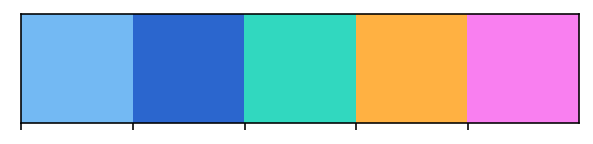

In [6]:
sns.palplot(sns.color_palette(colors_single))

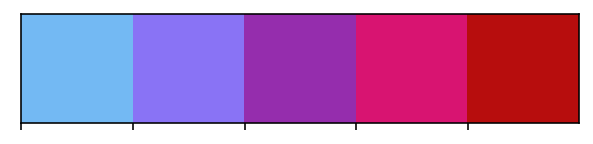

In [7]:
sns.palplot(sns.color_palette(colors_addin))

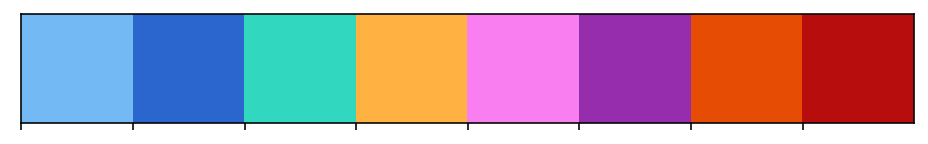

In [8]:
sns.palplot(sns.color_palette(colors_scale))

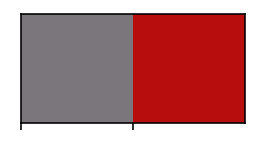

In [9]:
sns.palplot(sns.color_palette(colors_cov))

# Loading in data

Load in 70-model recovery test result dictionaries:

In [10]:
results_dict_dir = '../data_products/results_dicts'

In [11]:
chaintag_prior = 'prior'
prior_dict = utils.construct_results_dict(chaintag_prior)

In [12]:
fn_results_dict_single = f'{results_dict_dir}/results_dict_single.npy'
results_dict_single = np.load(fn_results_dict_single, allow_pickle=True).item()

In [13]:
fn_results_dict_addin_full = f'{results_dict_dir}/results_dict_addin_full.npy'
results_dict_addin_full = np.load(fn_results_dict_addin_full, allow_pickle=True).item()

In [14]:
fn_results_dict_wpmaxscale6 = f'{results_dict_dir}/results_dict_wpmaxscale6.npy'
results_dict_wpmaxscale6 = np.load(fn_results_dict_wpmaxscale6, allow_pickle=True).item()

In [15]:
fn_results_dict_minscales = f'{results_dict_dir}/results_dict_minscales.npy'
results_dict_minscales = np.load(fn_results_dict_minscales, allow_pickle=True).item()

In [16]:
fn_results_dict_maxscales = f'{results_dict_dir}/results_dict_maxscales.npy'
results_dict_maxscales = np.load(fn_results_dict_maxscales, allow_pickle=True).item()

# Figures (Main paper body)

### Emulator 3-panel accuracy plot

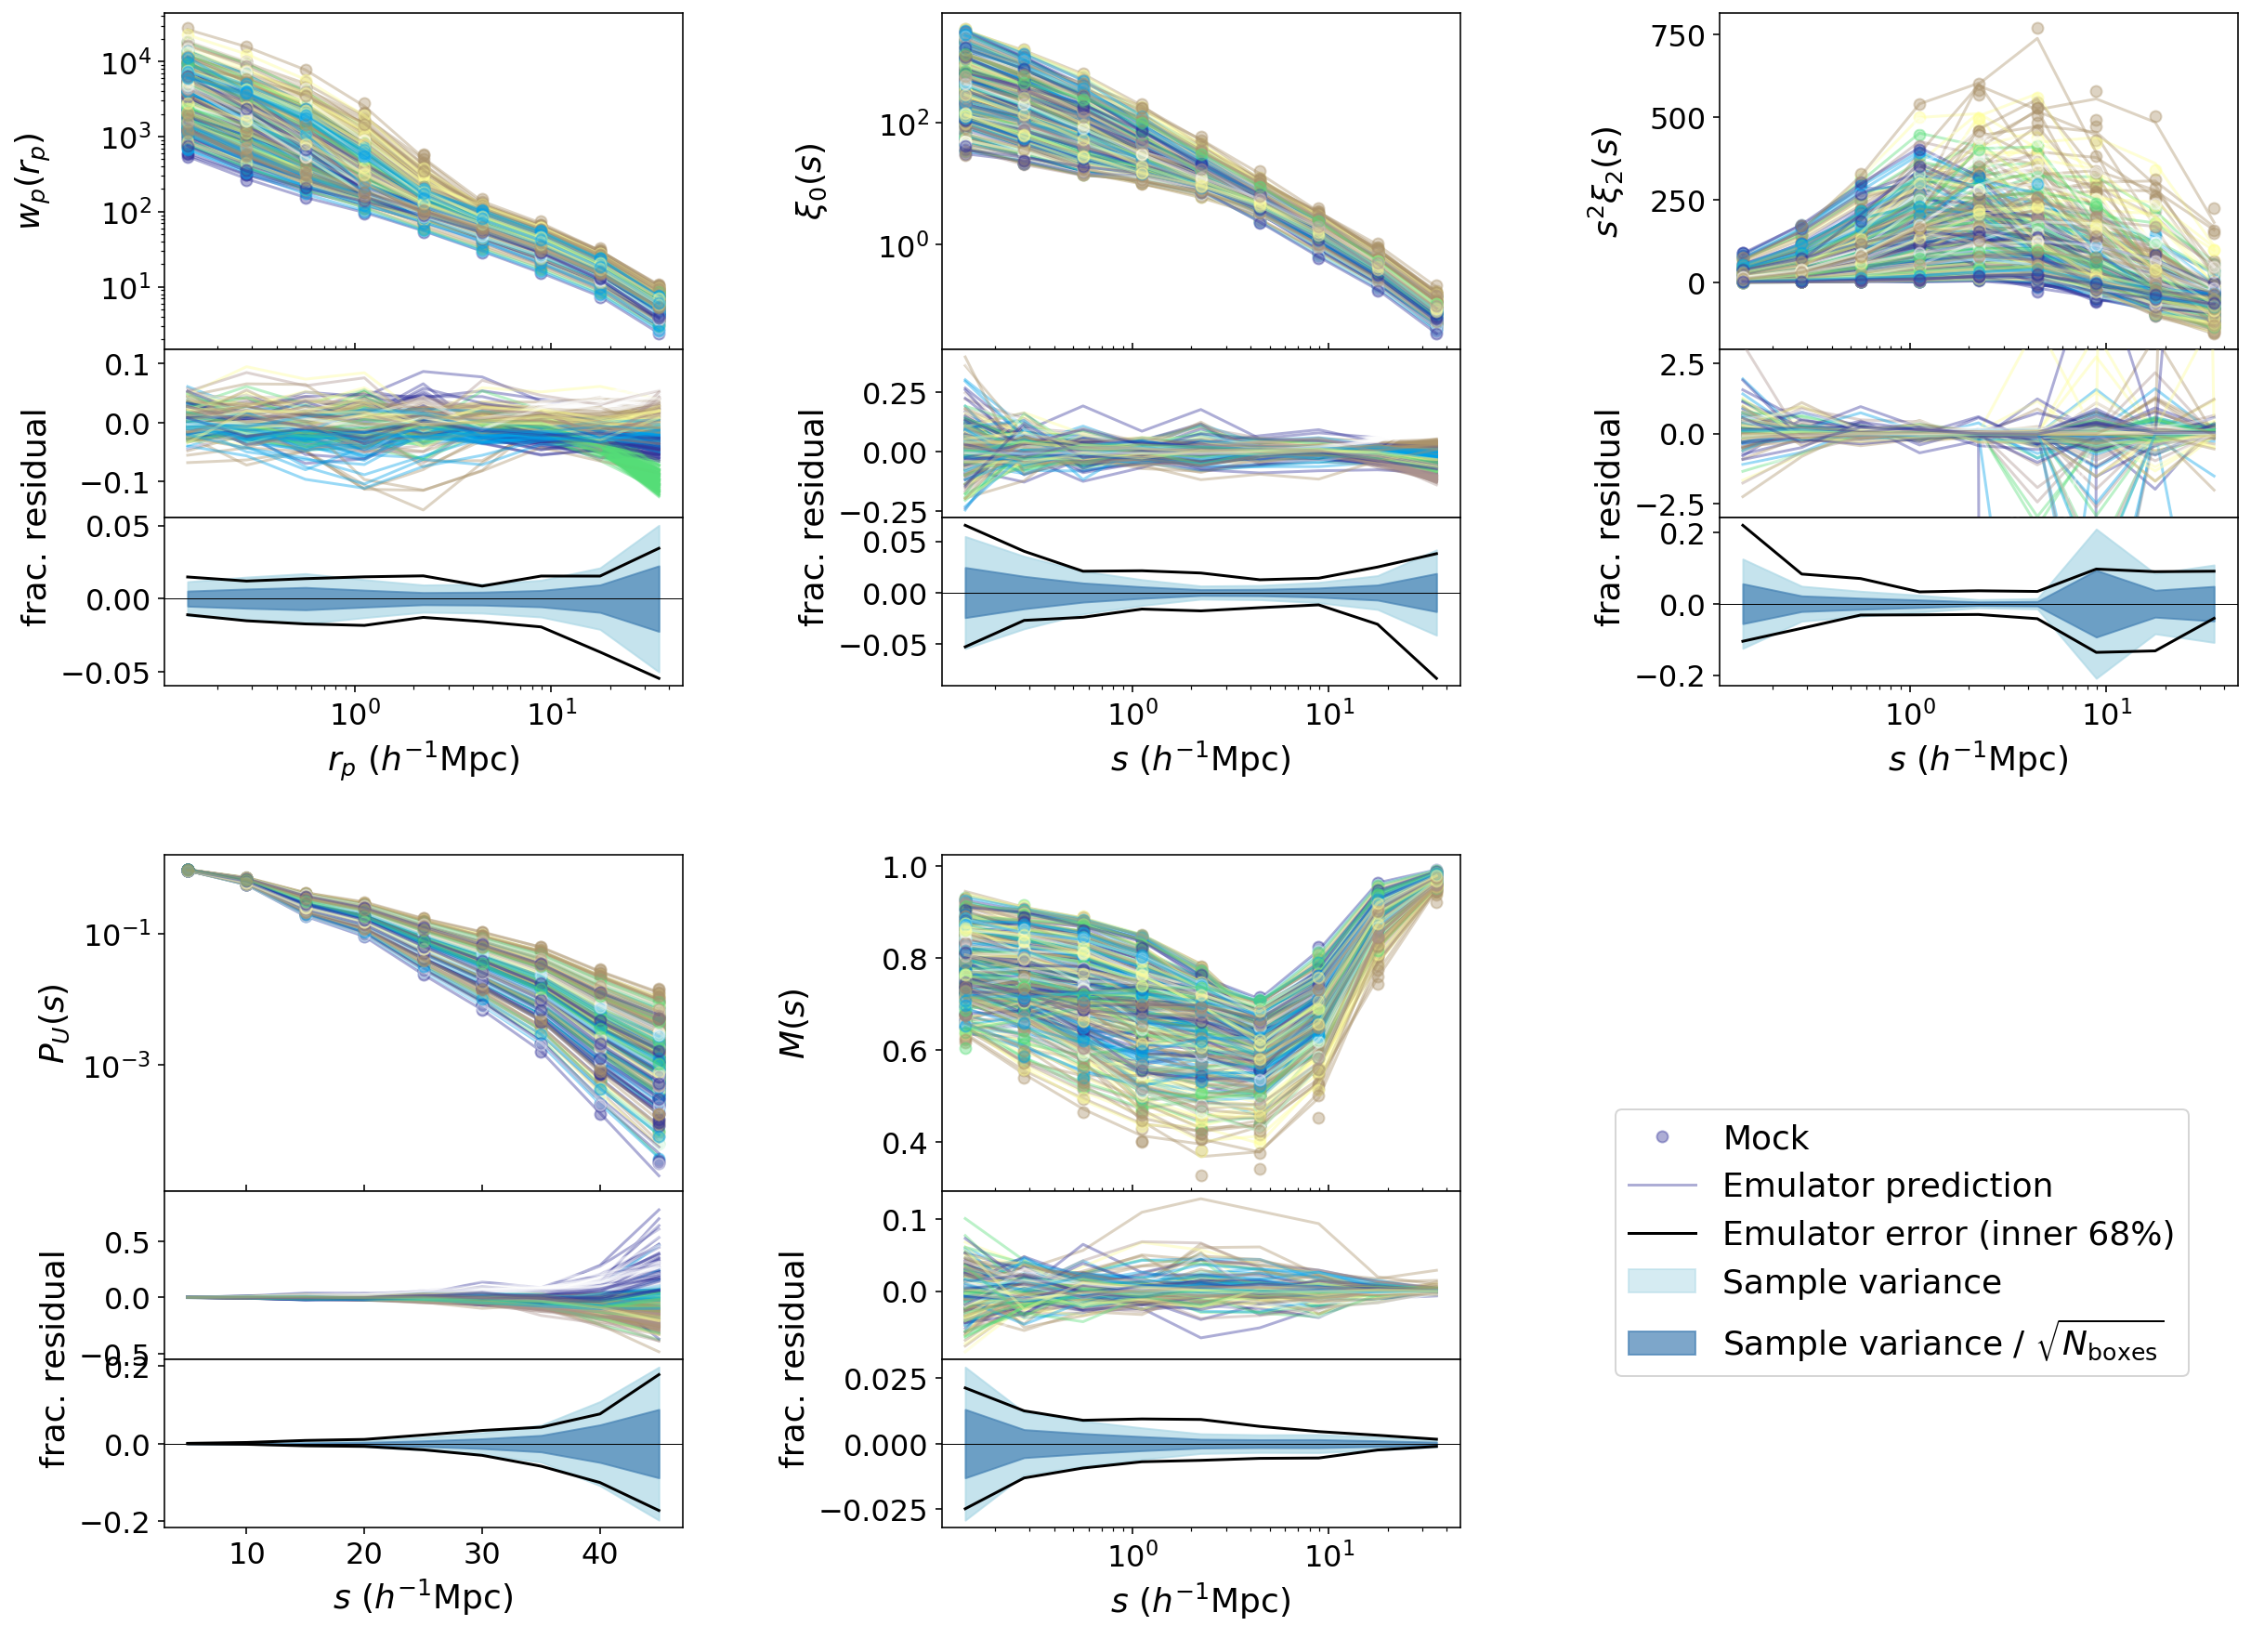

In [18]:
train_tags = [f'_{utils.get_fiducial_emu_name(s)}_{utils.get_fiducial_emu_scaling(s)}' for s in statistics]
plotter.plot_accuracy_figure(statistics, train_tags)
plt.savefig(f'{plot_dir}/emu_accuracy.pdf', bbox_inches='tight')

### Figure 2. Covariance matrices: a) sample variance; b) emulator performance

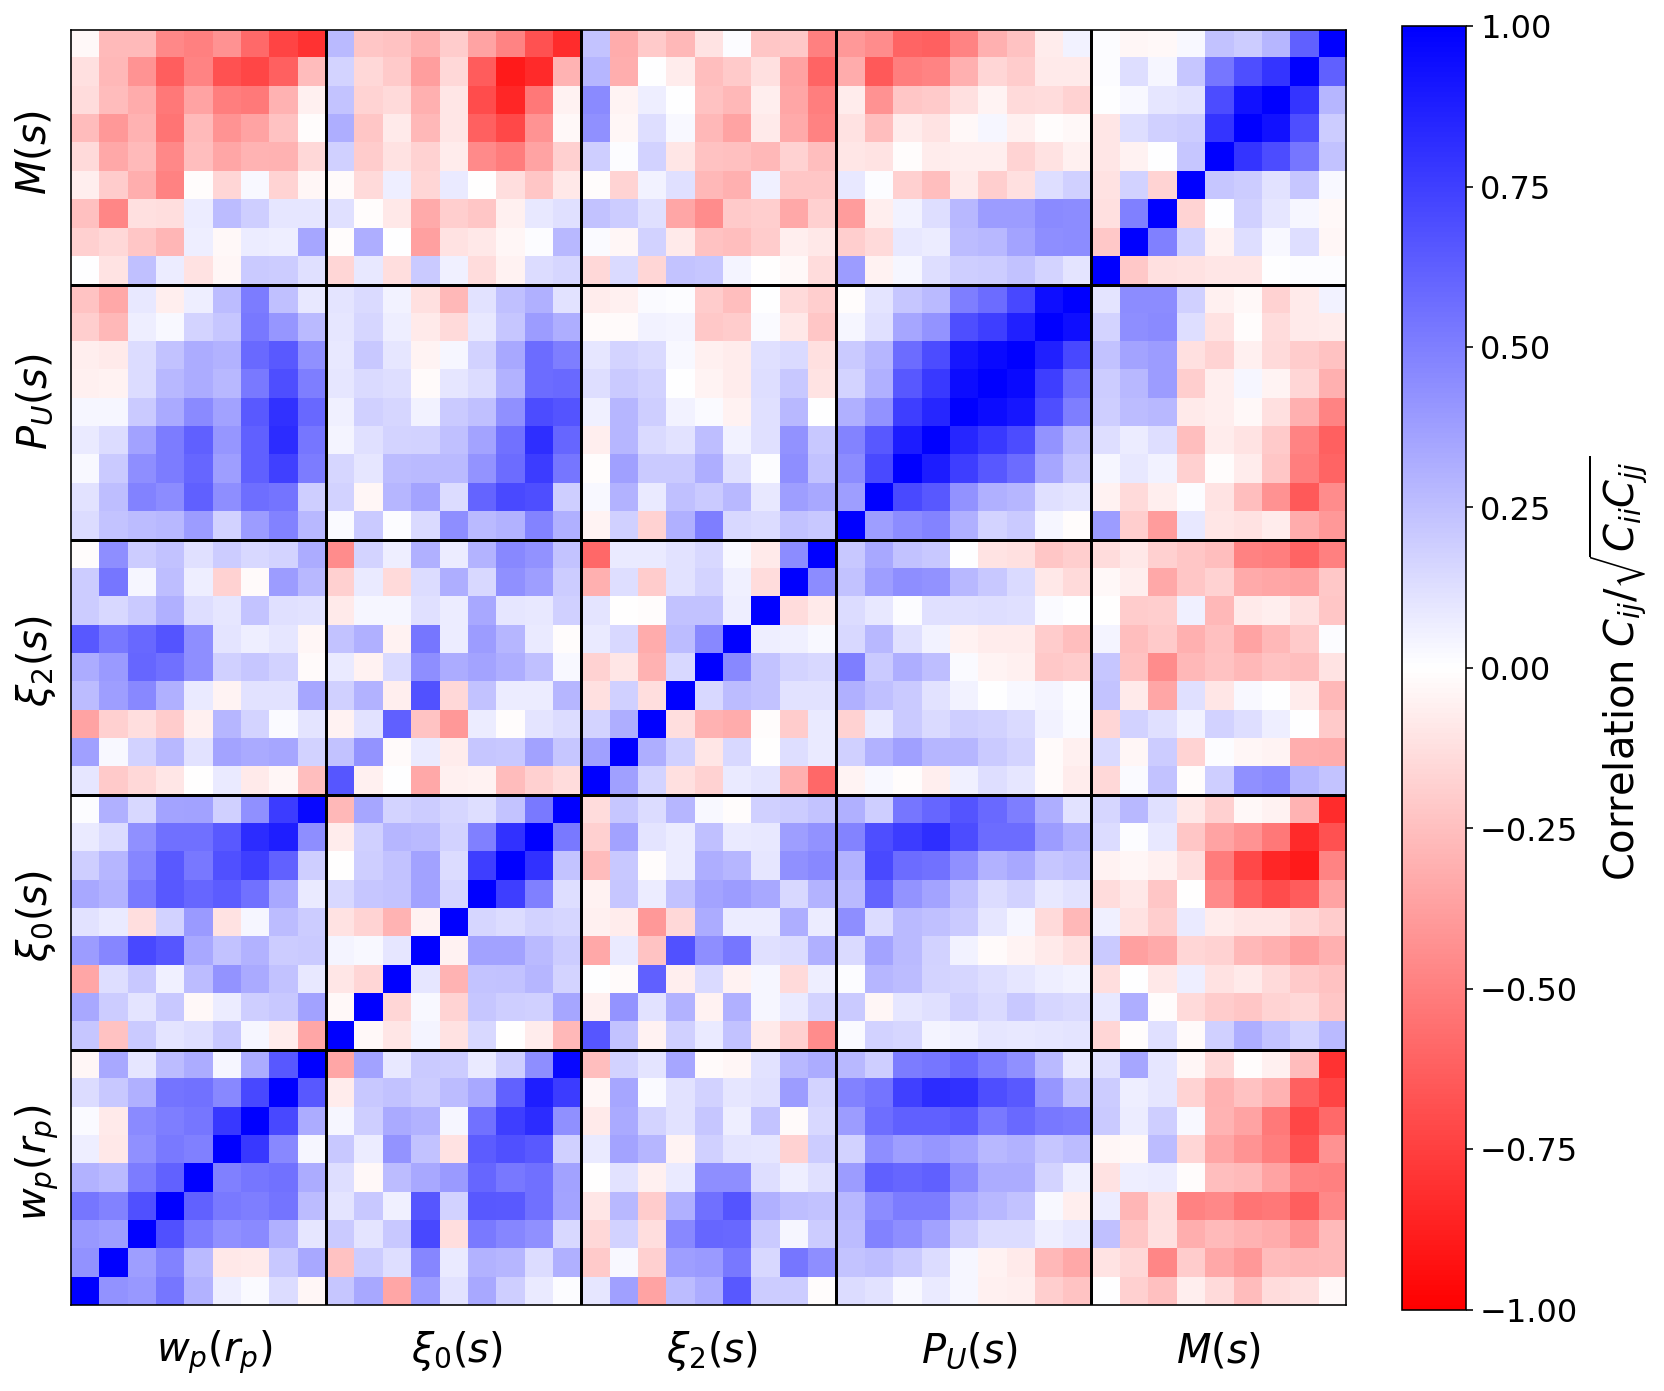

In [19]:
cov_tag = 'aemulus'
errtag = '_hod3_test0'

cov_dir = '../covariances'    
stat_str = '_'.join(statistics)
cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"
cov_smooth_fn = f"{cov_dir}/cov_smoothgauss_{cov_tag}_{stat_str}{errtag}.dat"

cov = np.loadtxt(cov_fn)
corr = utils.reduced_covariance(cov)
plotter.plot_correlation_matrix(corr, statistics)
plt.savefig(f'{plot_dir}/corr_aemulus.pdf', bbox_inches='tight')

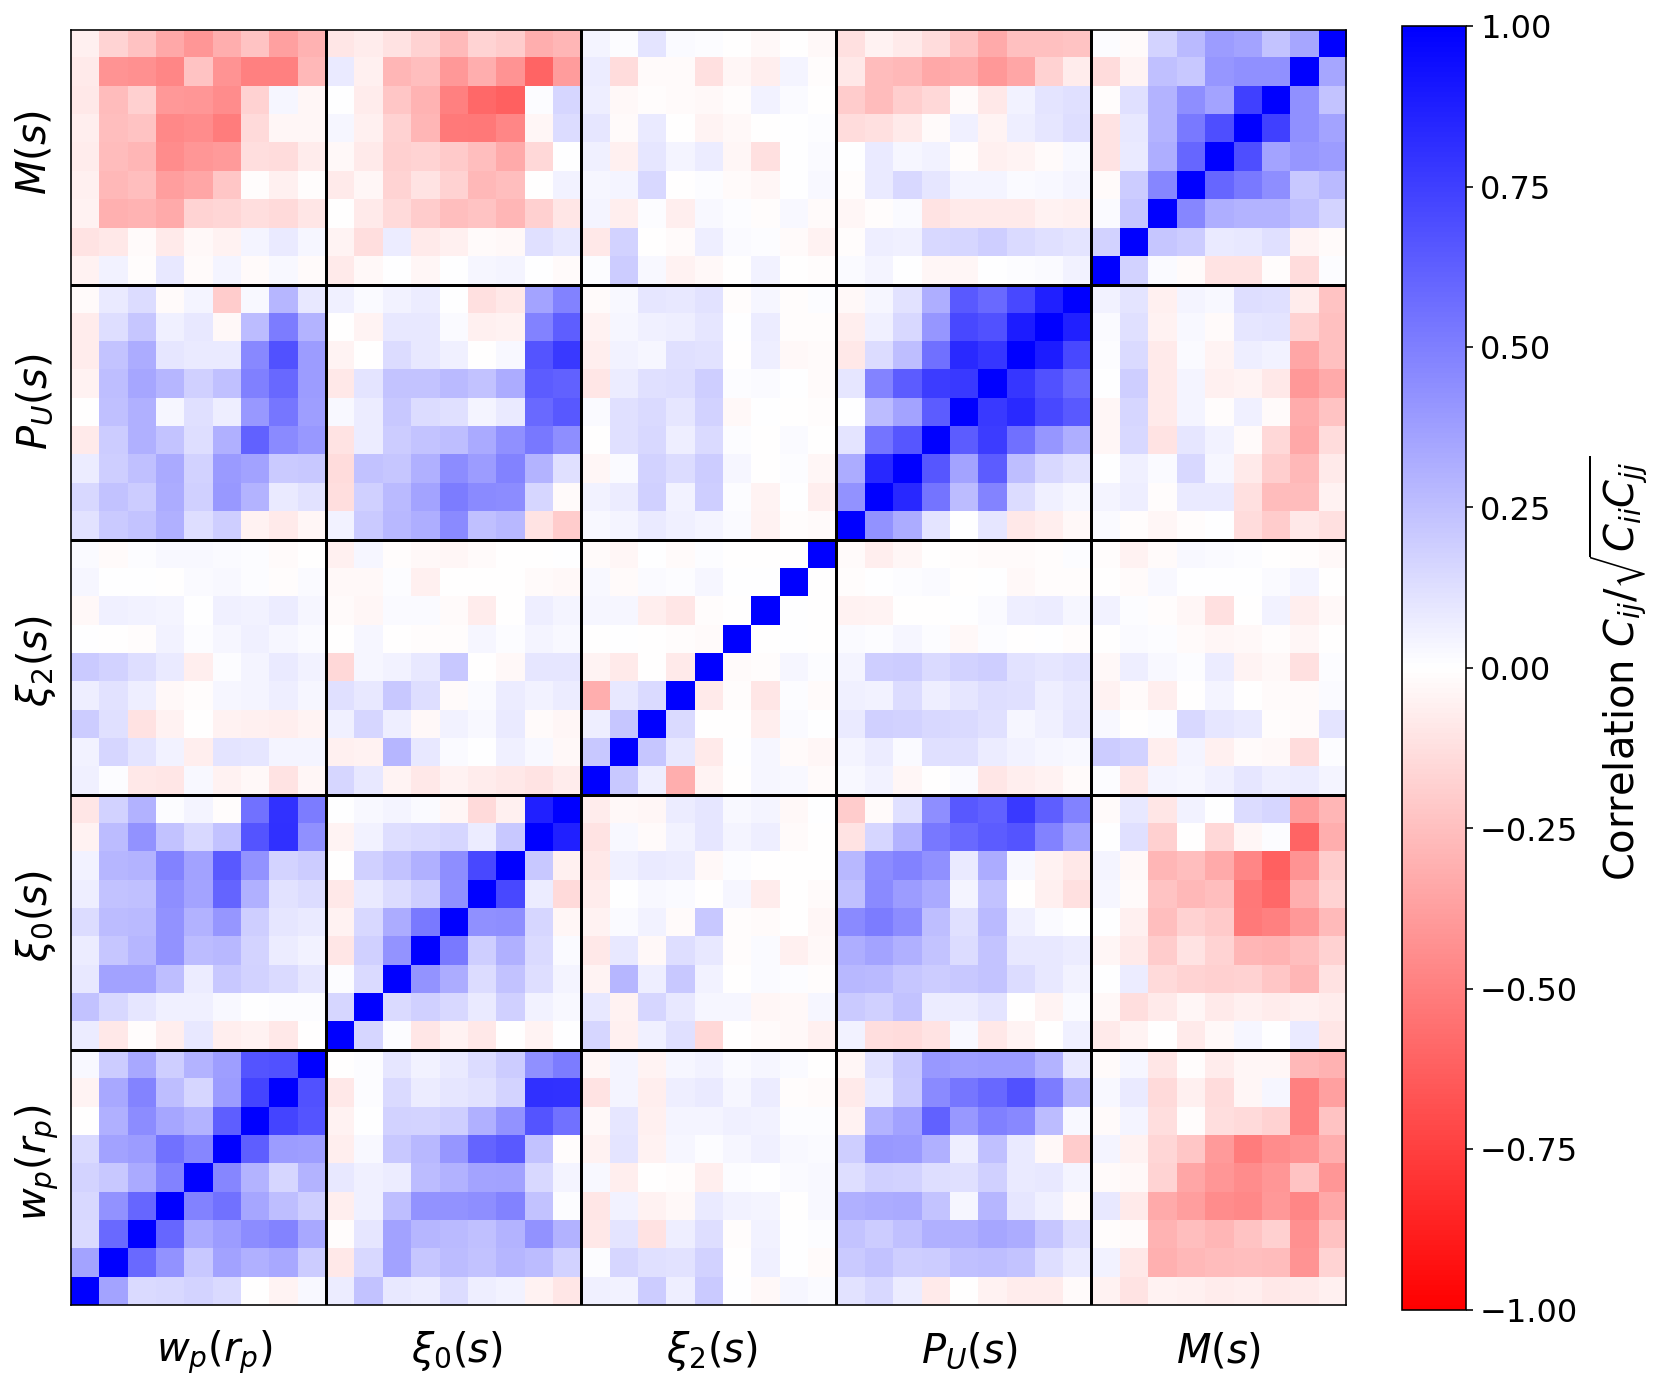

In [20]:
cov_tag = 'emuperf'
errtag = '_hod3_test0'

cov_dir = '../covariances'    
stat_str = '_'.join(statistics)
cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"

cov = np.loadtxt(cov_fn)
corr = utils.reduced_covariance(cov)
plotter.plot_correlation_matrix(corr, statistics)
plt.savefig(f'{plot_dir}/corr_emuperf.pdf', bbox_inches='tight')

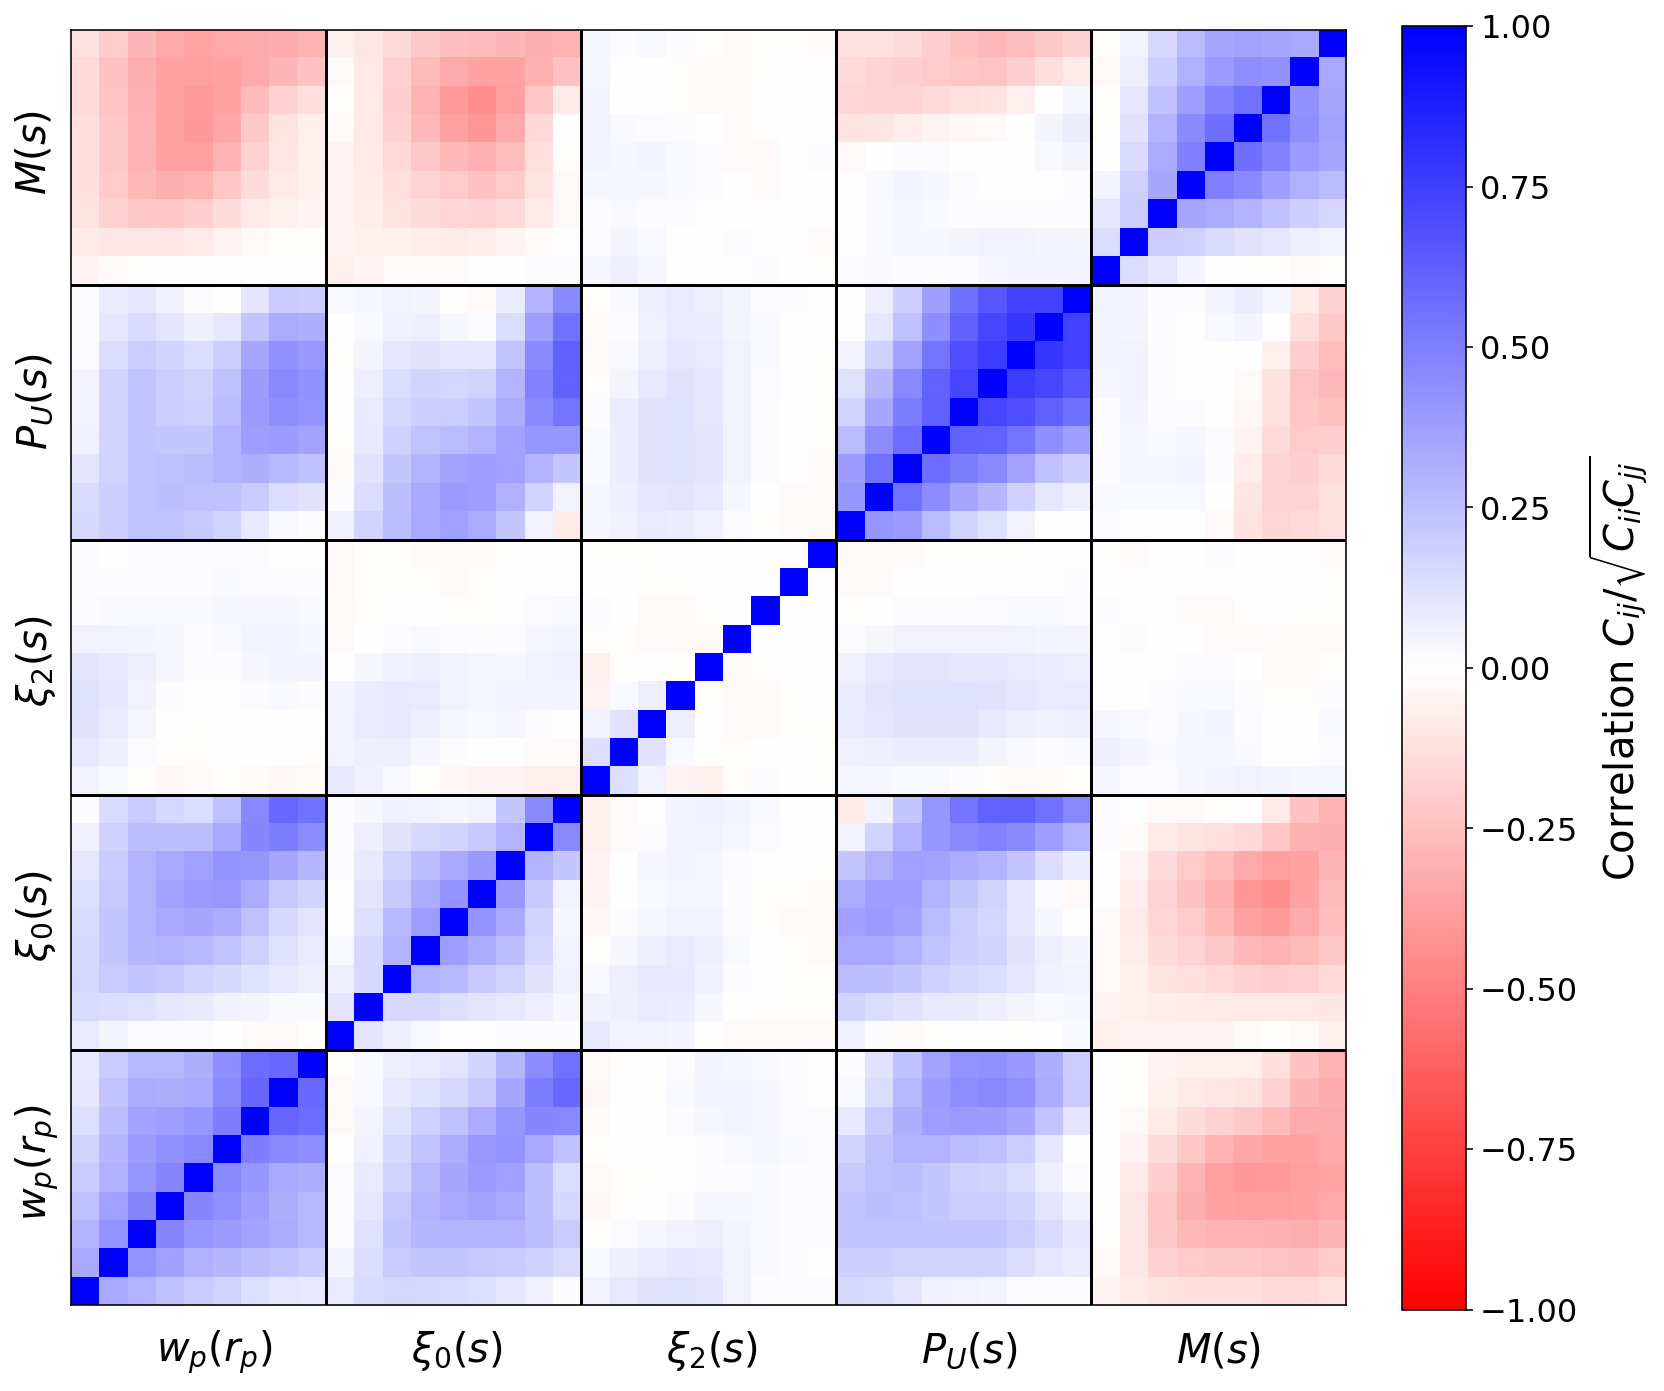

In [21]:
cov_tag = 'smoothgauss_emuperf'
errtag = '_hod3_test0'

cov_dir = '../covariances'    
stat_str = '_'.join(statistics)
cov_fn = f"{cov_dir}/cov_{cov_tag}_{stat_str}{errtag}.dat"

cov = np.loadtxt(cov_fn)
corr = utils.reduced_covariance(cov)
plotter.plot_correlation_matrix(corr, statistics)
plt.savefig(f'{plot_dir}/corr_smoothgauss_emuperf.pdf', bbox_inches='tight')

### Contour plots, single observables

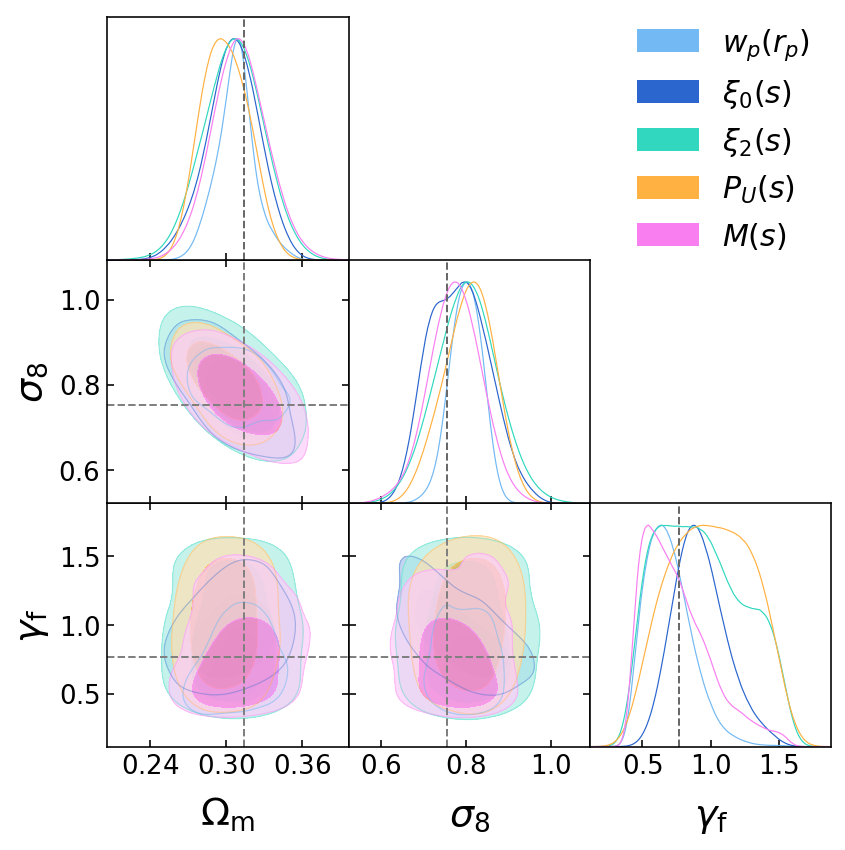

In [22]:
chaintags = [
             'wp_c1h12_all',
             'xi_c1h12_all',
             'xi2_c1h12_all',
             'upf_c1h12_all',
             'mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, legend_labels=labels_single,
                          colors=colors_single, legend_loc=(0.74,0.69),
                          legend_fontsize=18,
                          params_toplot=params_keycosmo, alpha=0.7)
plt.savefig(f'{plot_dir}/contour_single_cosmo.pdf', bbox_inches='tight')

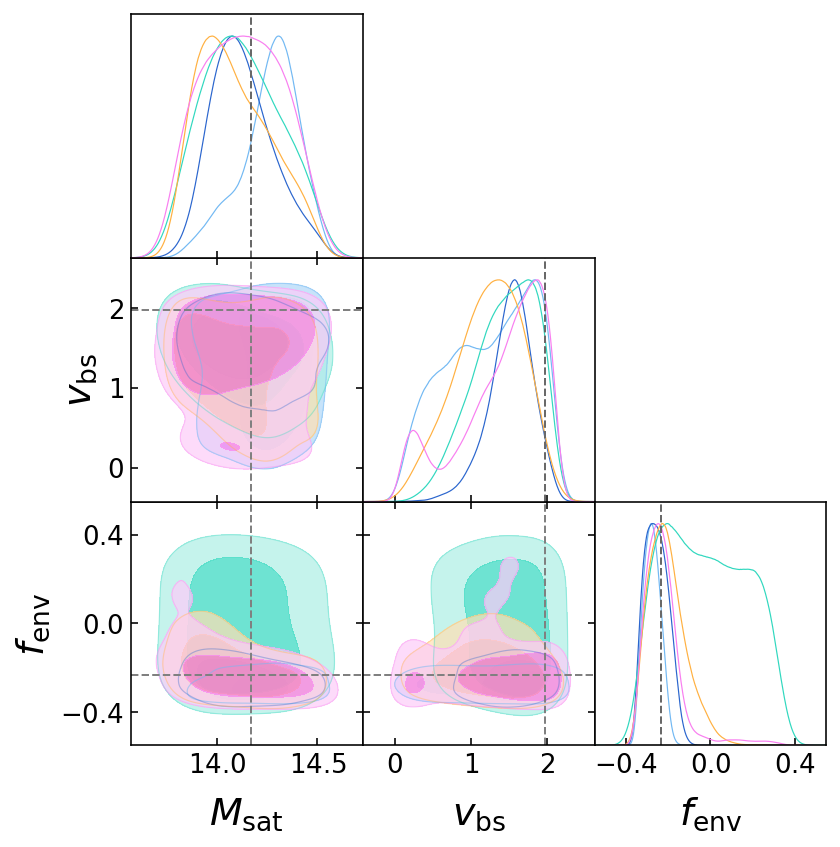

In [23]:
chaintags = [
             'wp_c1h12_all',
             'xi_c1h12_all',
             'xi2_c1h12_all',
             'upf_c1h12_all',
             'mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors_single,
                          params_toplot=params_keyhodab, alpha=0.7)
plt.savefig(f'{plot_dir}/contour_single_hodab.pdf', bbox_inches='tight')

### Contour plots, adding in observables

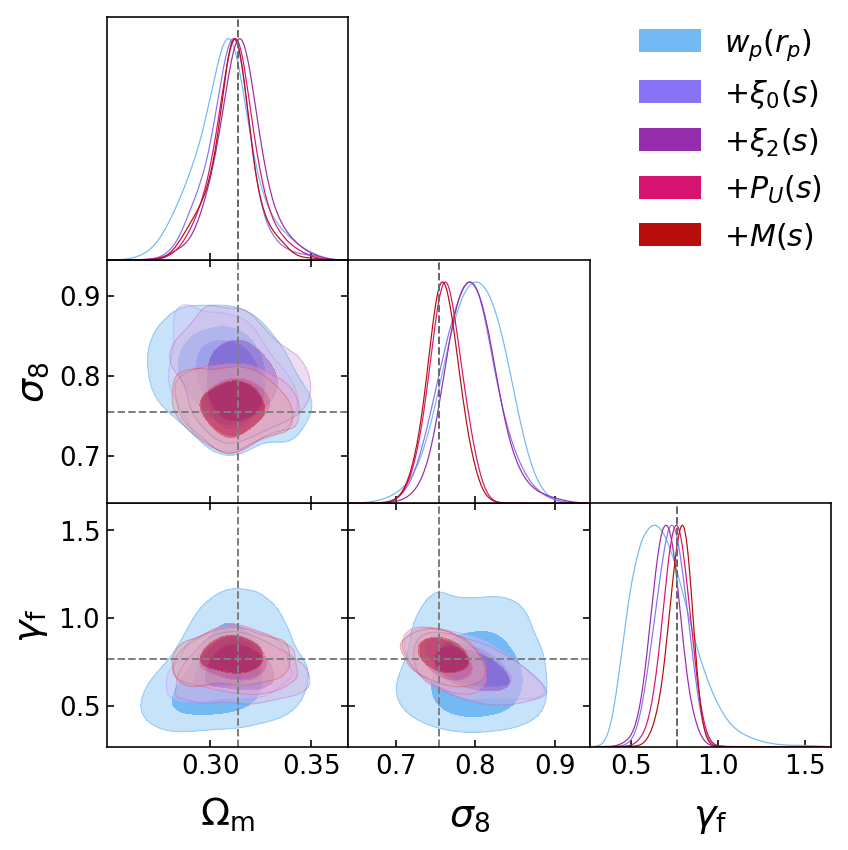

In [24]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, legend_labels=labels_addin,
                          colors=colors_addin, legend_loc=(0.74,0.69),
                          legend_fontsize=18,
                          params_toplot=params_keycosmo)
plt.savefig(f'{plot_dir}/contour_addin_cosmo.pdf', bbox_inches='tight')

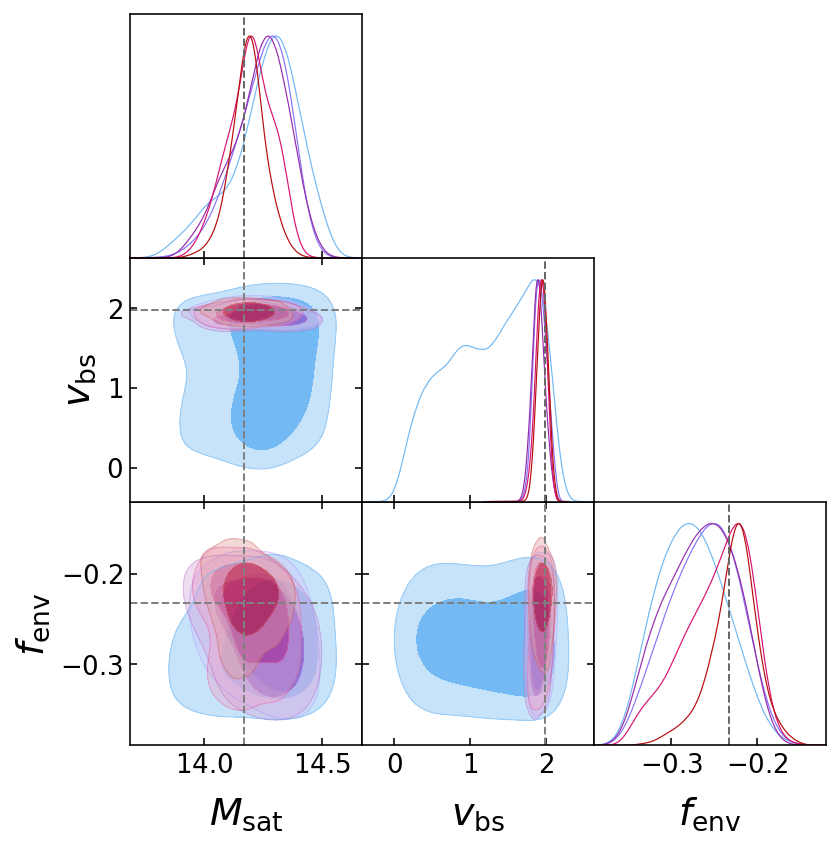

In [25]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors_addin,
                          params_toplot=params_keyhodab)
plt.savefig(f'{plot_dir}/contour_addin_hodab.pdf', bbox_inches='tight')

### 70-model recovery test for single observables

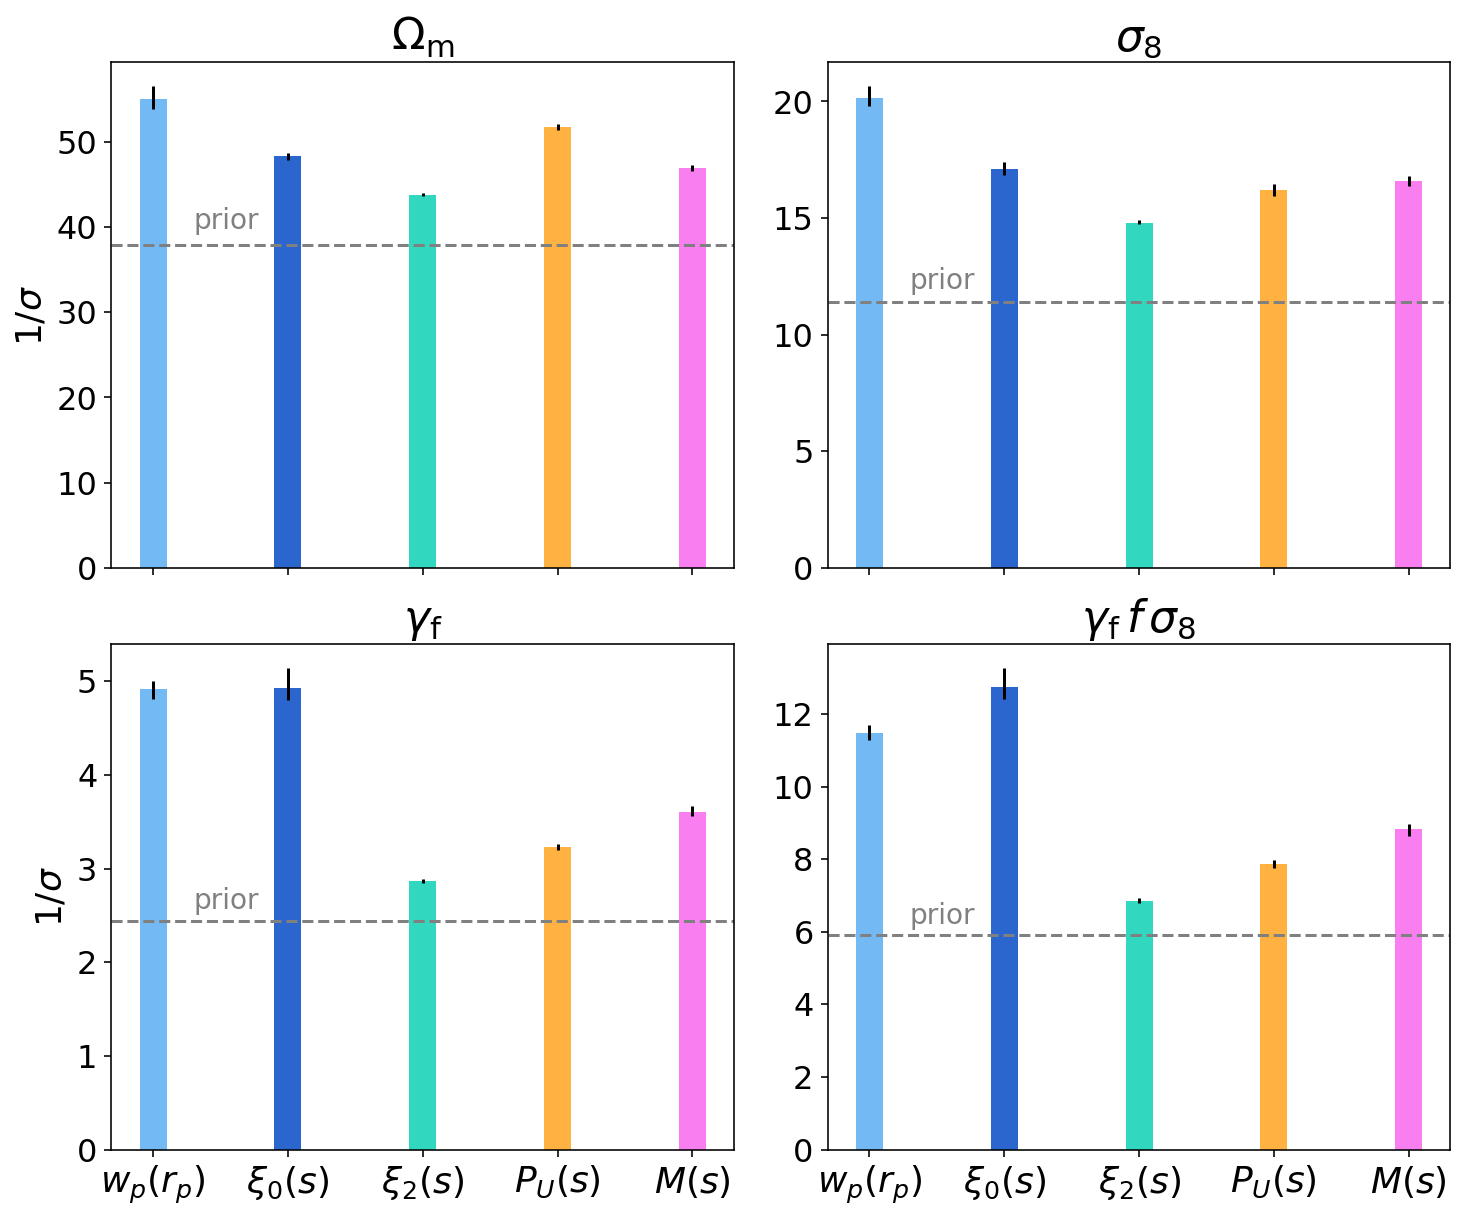

In [46]:
plotter.plot_uncertainty_figure(results_dict_single, prior_dict, params_keydeliverable, stat_strs_single, id_pairs, 
                                labels_single, colors_single)
plt.savefig(f'{plot_dir}/recovery_single.pdf', bbox_inches='tight')

### 70-model recovery test for adding in observables

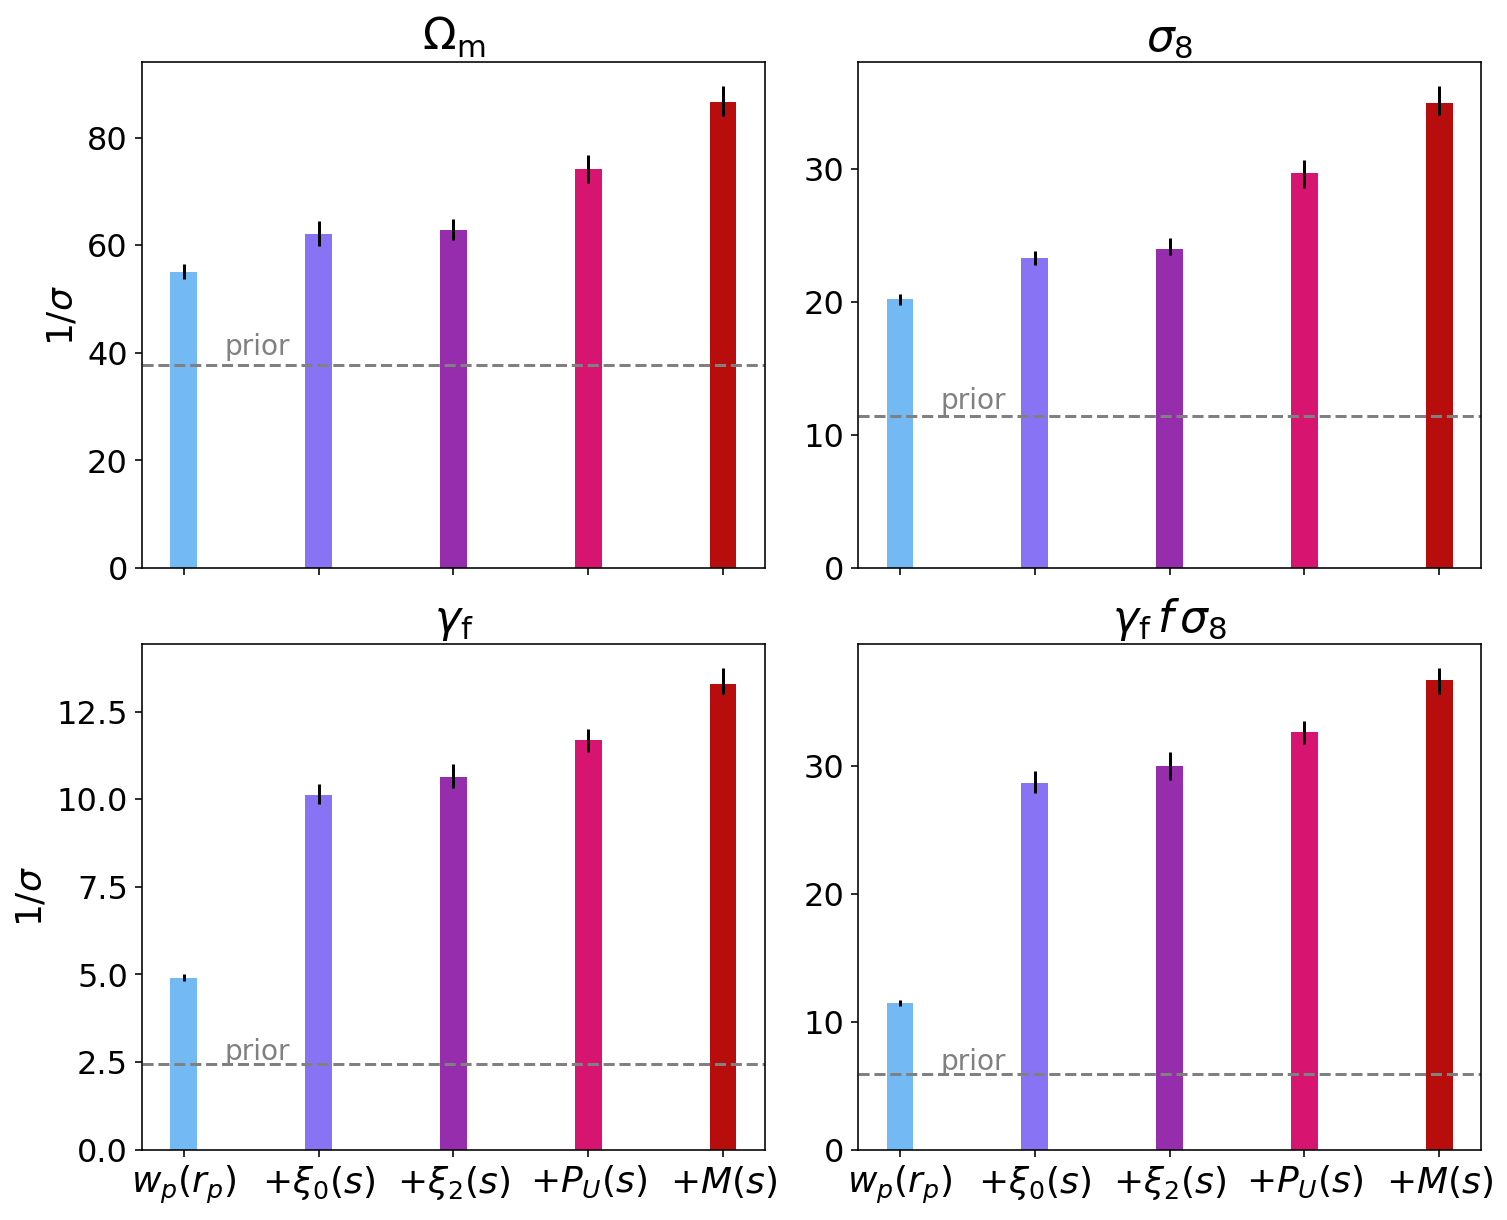

In [45]:
plotter.plot_uncertainty_figure(results_dict_addin_full, prior_dict, params_keydeliverable, stat_strs_addin_full, 
                                id_pairs, labels_addin, colors_addin)
plt.savefig(f'{plot_dir}/recovery_addin.pdf', bbox_inches='tight')

### 70-model recovery test: cumulative distribution function

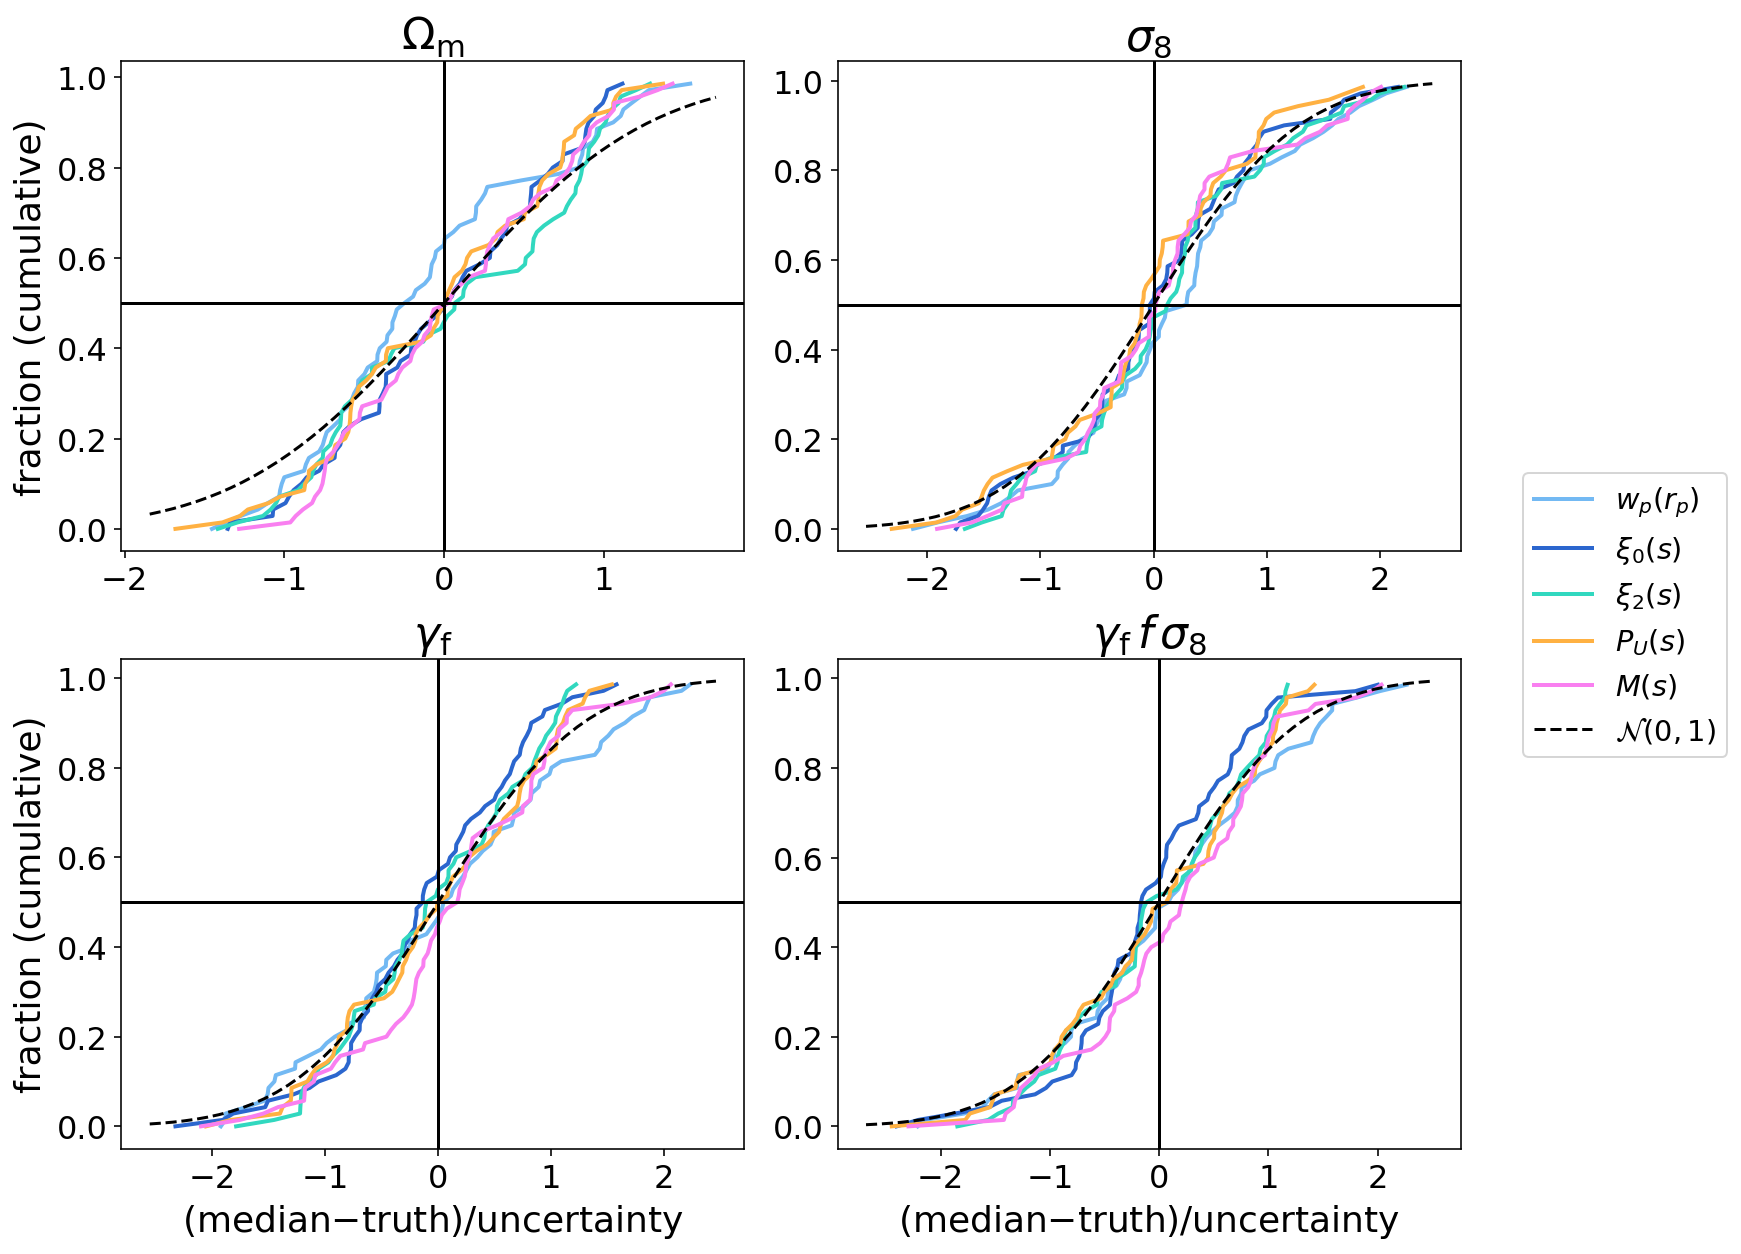

In [36]:
plotter.plot_cumulative_dist_figure(results_dict_single, params_keydeliverable, stat_strs_single, id_pairs, 
                                    labels_single, colors_single, divide_by_error=True)
plt.savefig(f'{plot_dir}/cdf_single.pdf', bbox_inches='tight')

In [29]:
# plotter.plot_cumulative_dist_figure(results_dict_addin_full, params_keydeliverable, stat_strs_addin_full, id_pairs, 
#                                     labels_addin, colors_addin, divide_by_error=True)
# plt.savefig(f'{plot_dir}/cdf_addin.pdf', bbox_inches='tight')

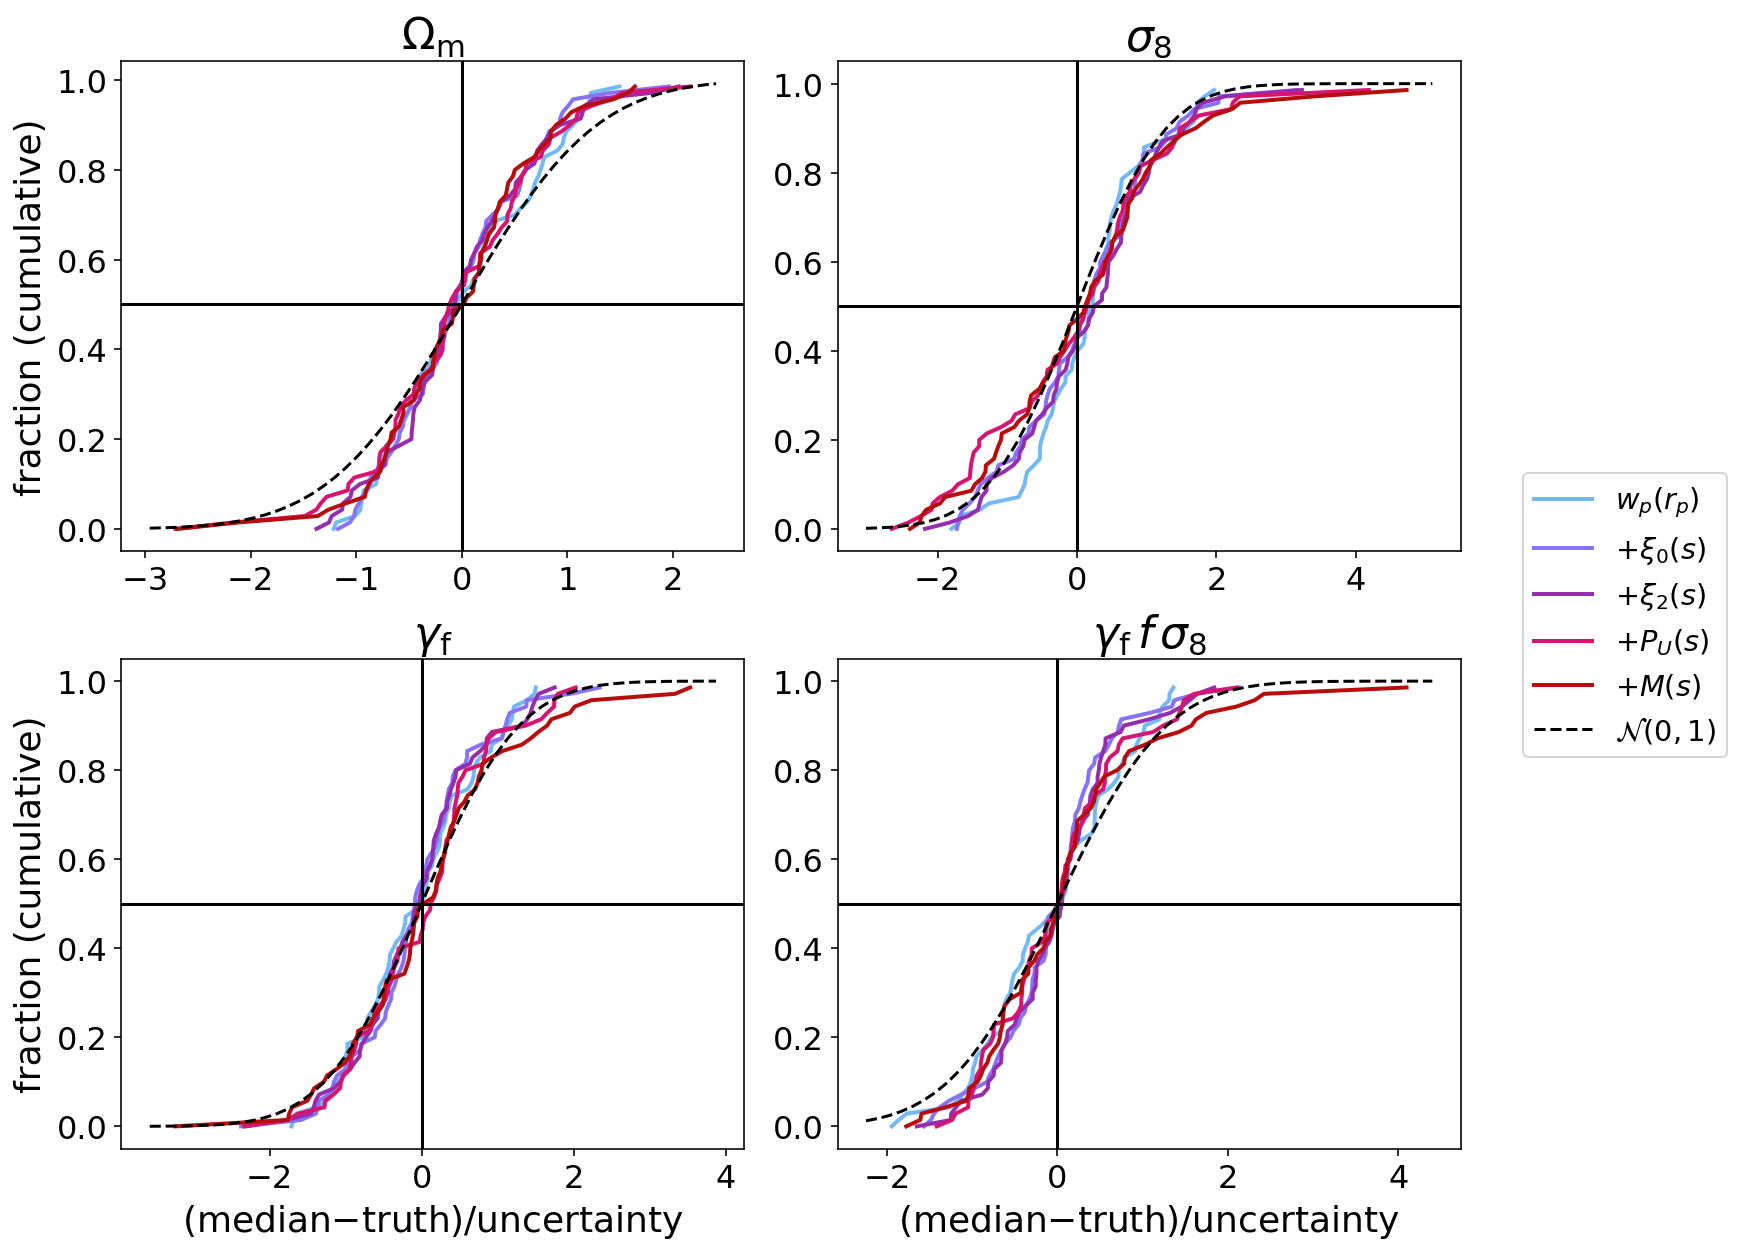

In [35]:
plotter.plot_cumulative_dist_figure(results_dict_wpmaxscale6, params_keydeliverable, stat_strs_addin_full, id_pairs, 
                                    labels_addin, colors_addin, divide_by_error=True)
plt.savefig(f'{plot_dir}/cdf_addin_wpmaxscale6.pdf', bbox_inches='tight')

### Scales analysis

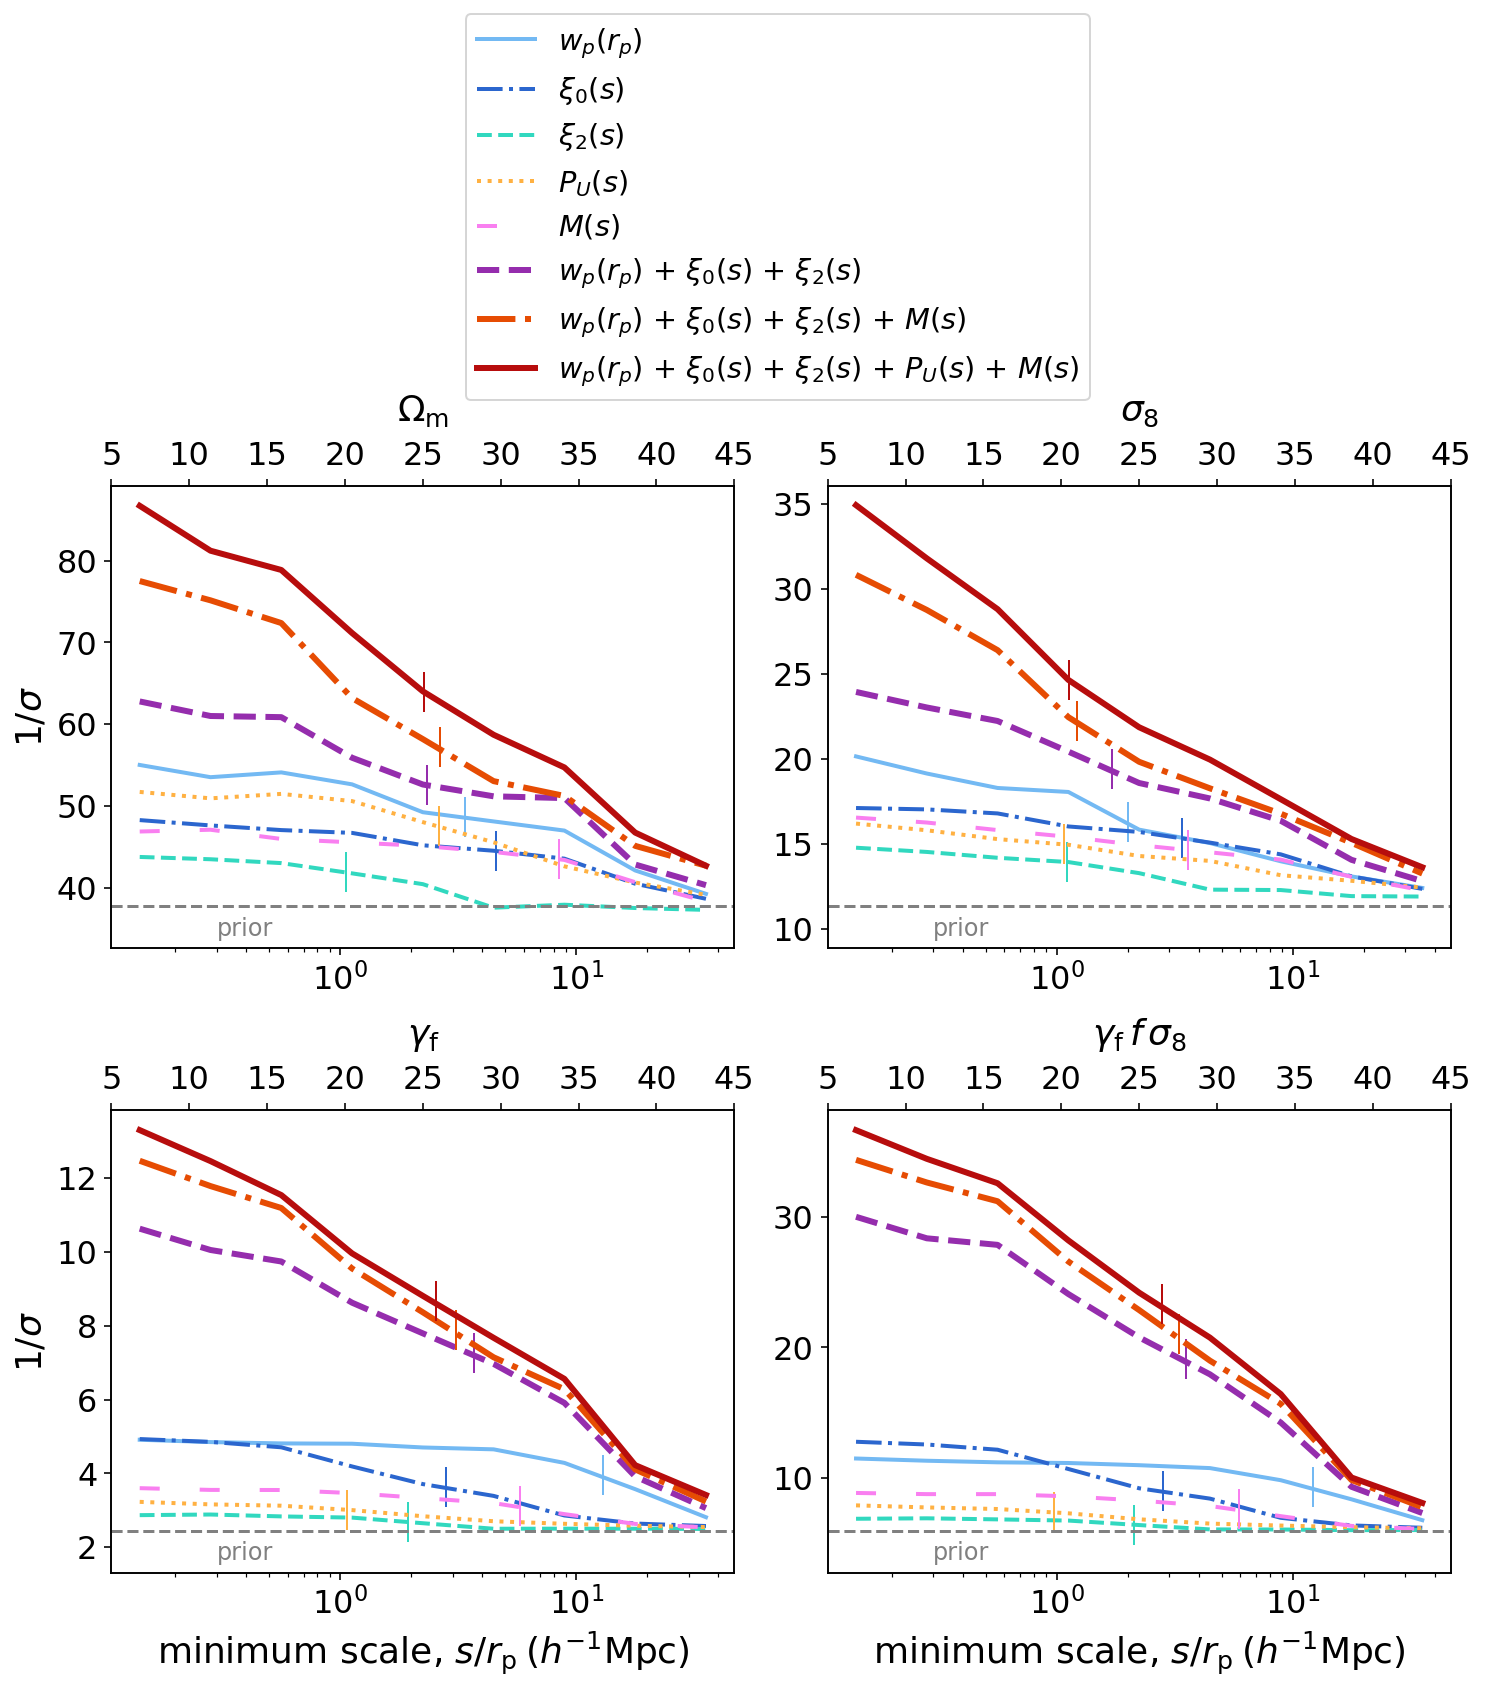

In [26]:
lws = [2,2,2,2,2,3,3,3]
long_dash = (0, (5, 10))
lss = ['-', '-.', '--', ':', long_dash, '--', '-.', '-']
min_scales = np.arange(0,9)
plotter.plot_scale_dependence_figure(min_scales, results_dict_minscales, prior_dict, 
                             params_keydeliverable, stat_strs_scale, id_pairs, labels_scale, colors_scale,
                             lss=lss, lws=lws, xlabel=r'minimum scale, $s/r_\mathrm{p} \: (h^{-1}\mathrm{Mpc})$',
                             comparison_dicts=results_dict_maxscales)
plt.savefig(f'{plot_dir}/scale_dependence.pdf', bbox_inches='tight')

# Appendix Figures

### Contour plots, single model recovery test: a) all cosmological parameters; b) all hod parameters; c) key cosmology + key HOD/AB parameters 

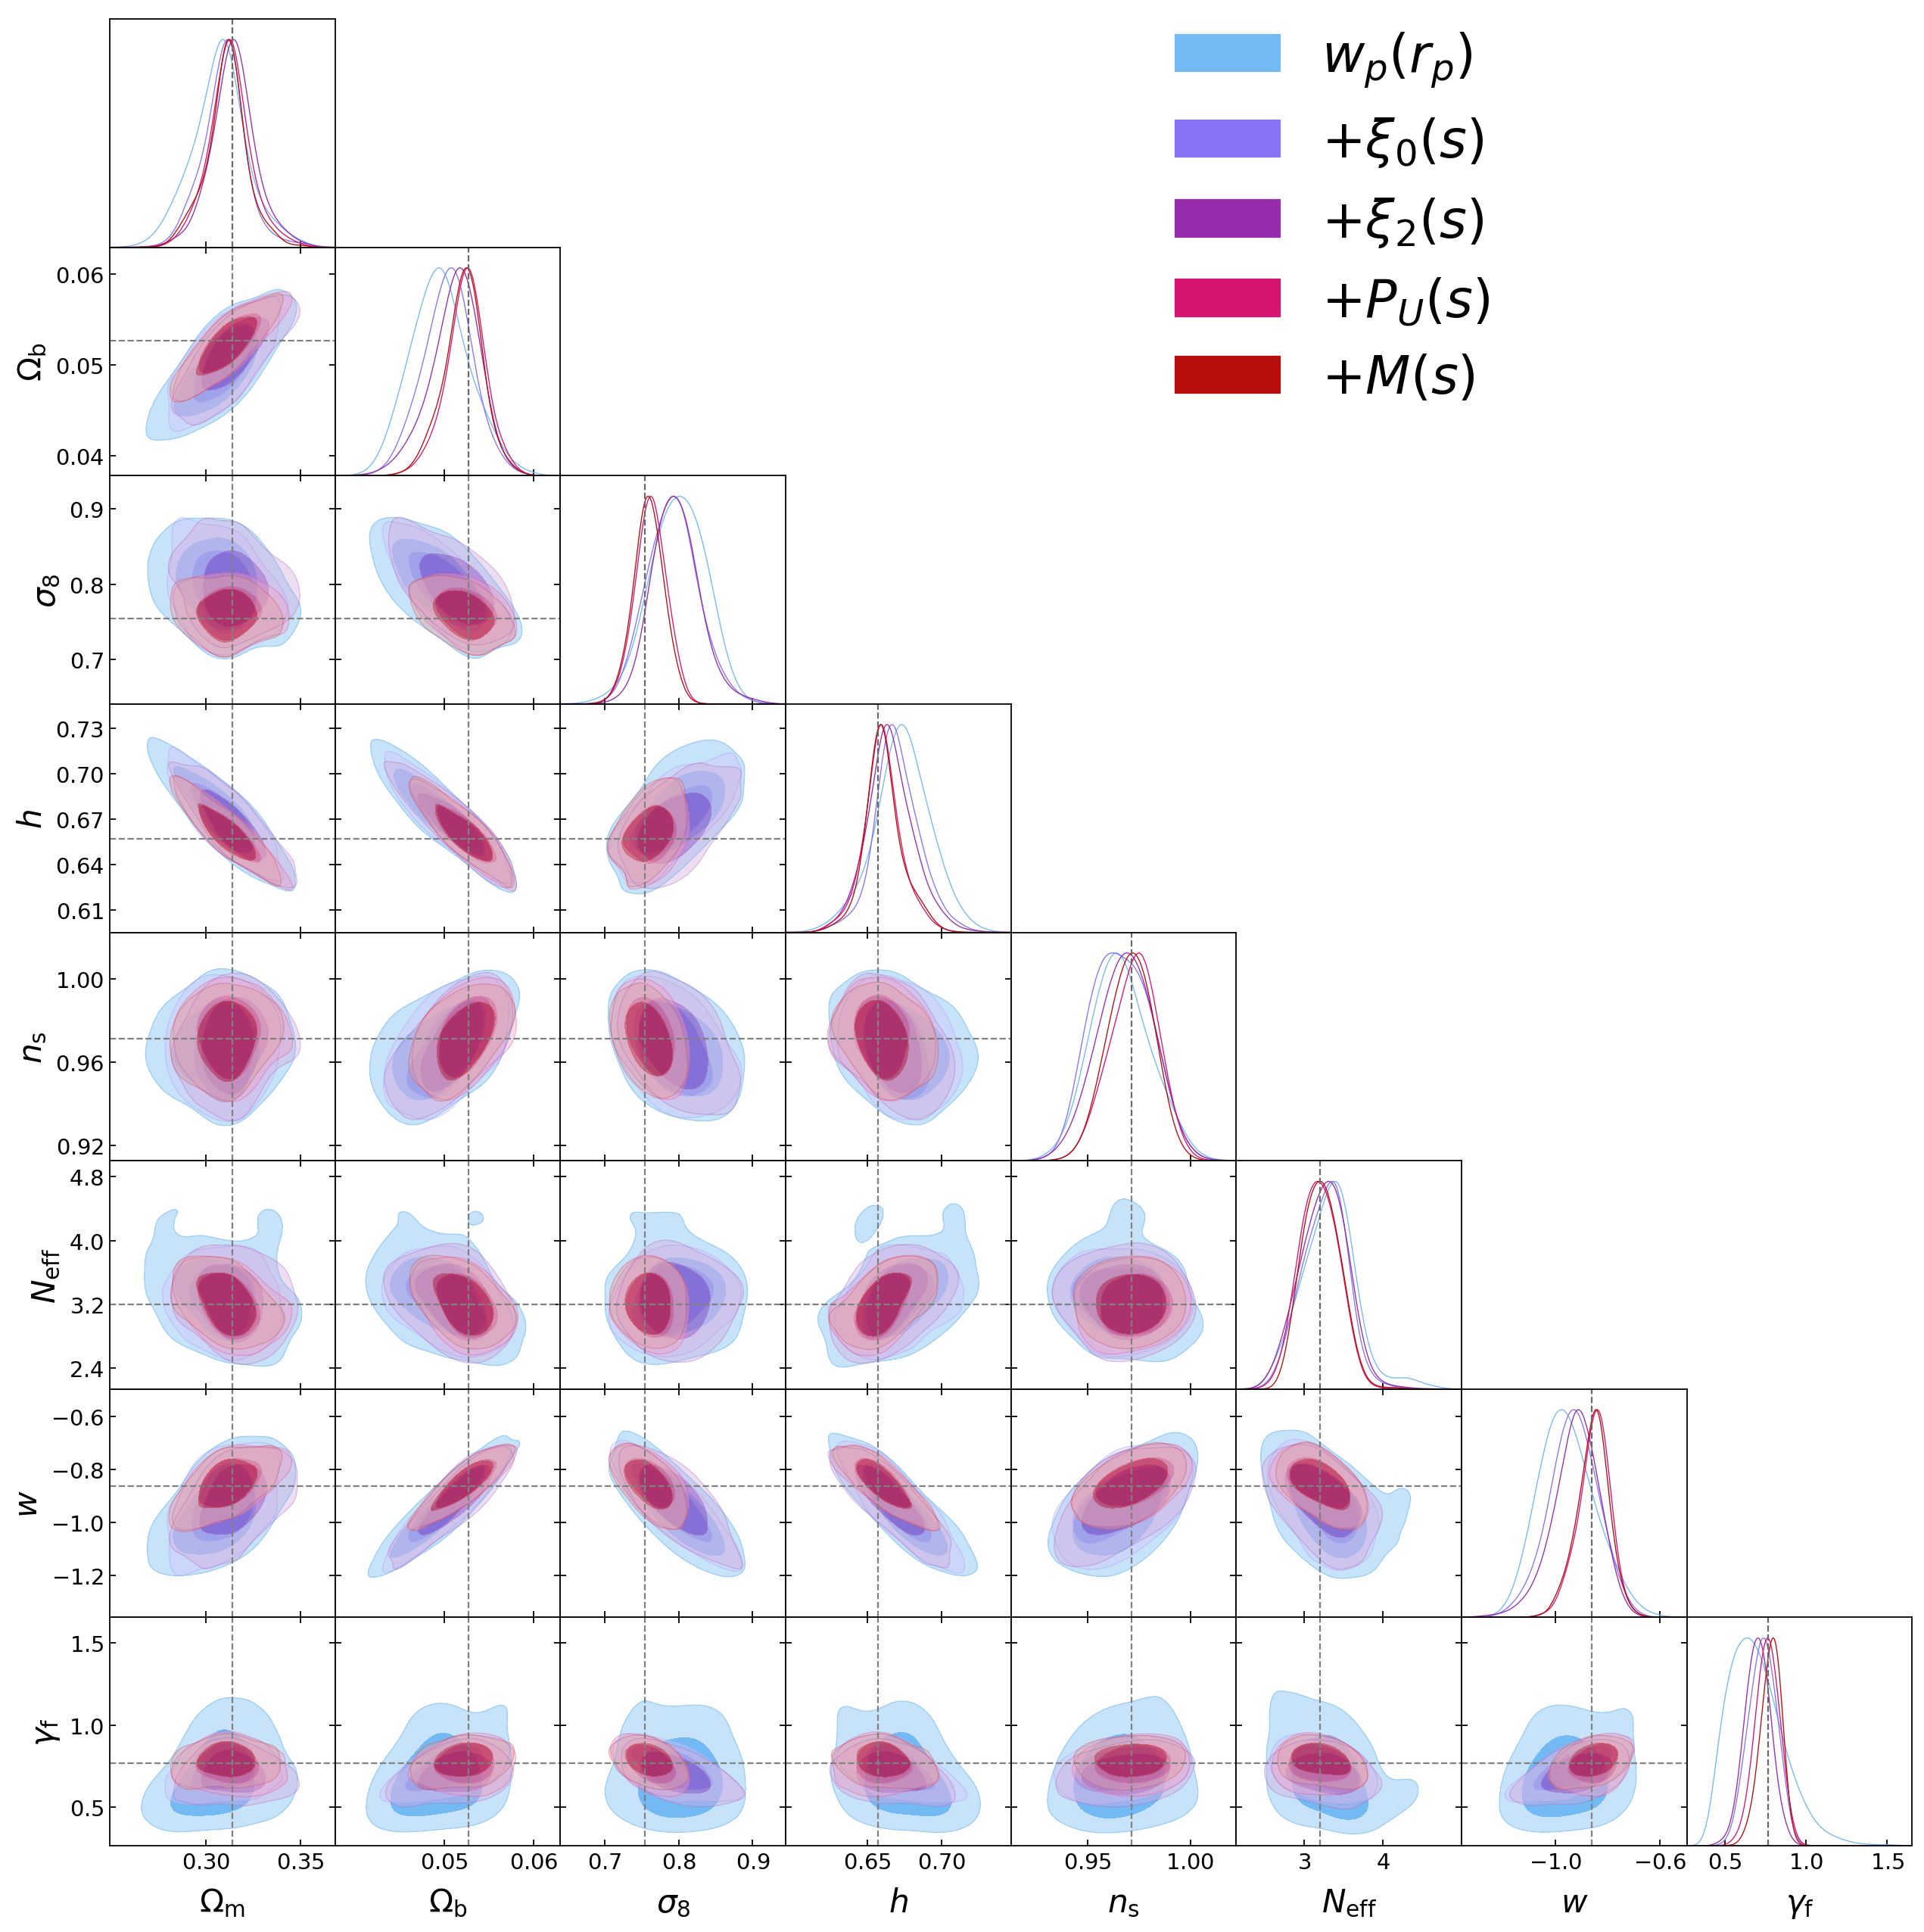

In [56]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, legend_labels=labels_addin,
                          colors=colors_addin, legend_loc=(0.6, 0.78),
                          legend_fontsize=34,
                          params_toplot=cosmo_withf_param_names)
plt.savefig(f'{plot_dir}/contour_addin_allcosmo.pdf', bbox_inches='tight')

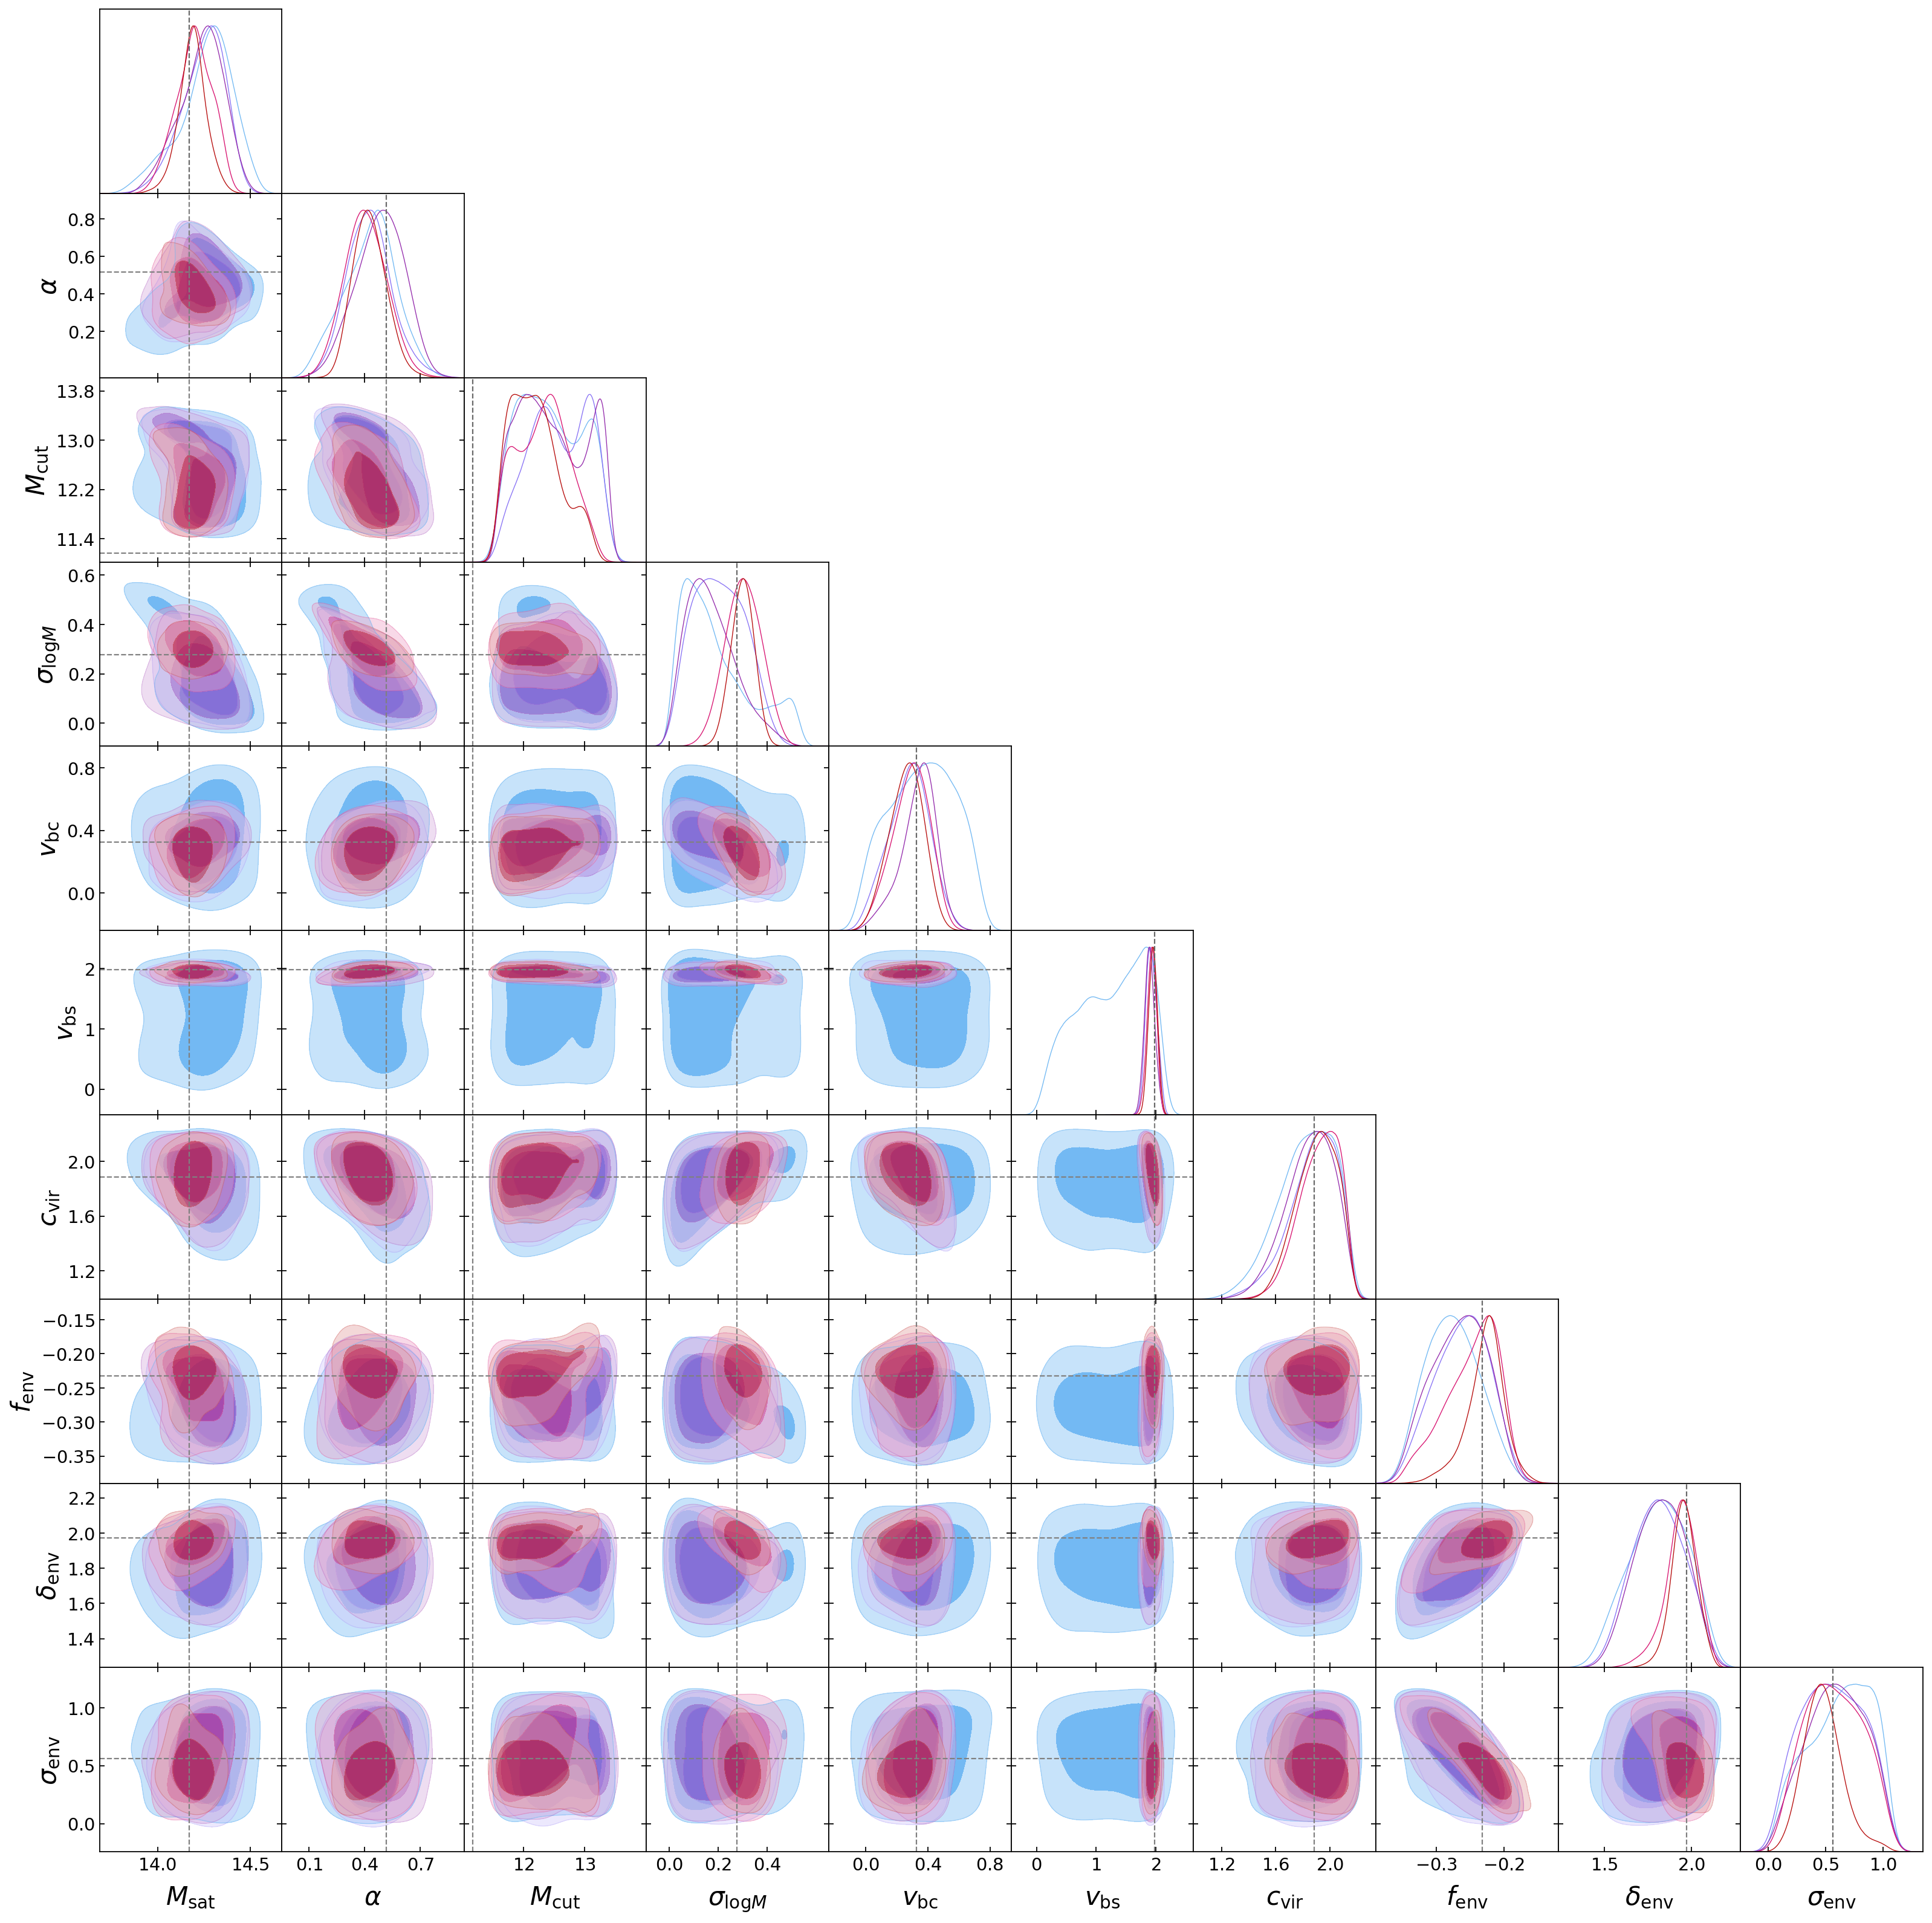

In [50]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors_addin,
                          params_toplot=hod_nof_param_names)
plt.savefig(f'{plot_dir}/contour_addin_allhodab.pdf', bbox_inches='tight')

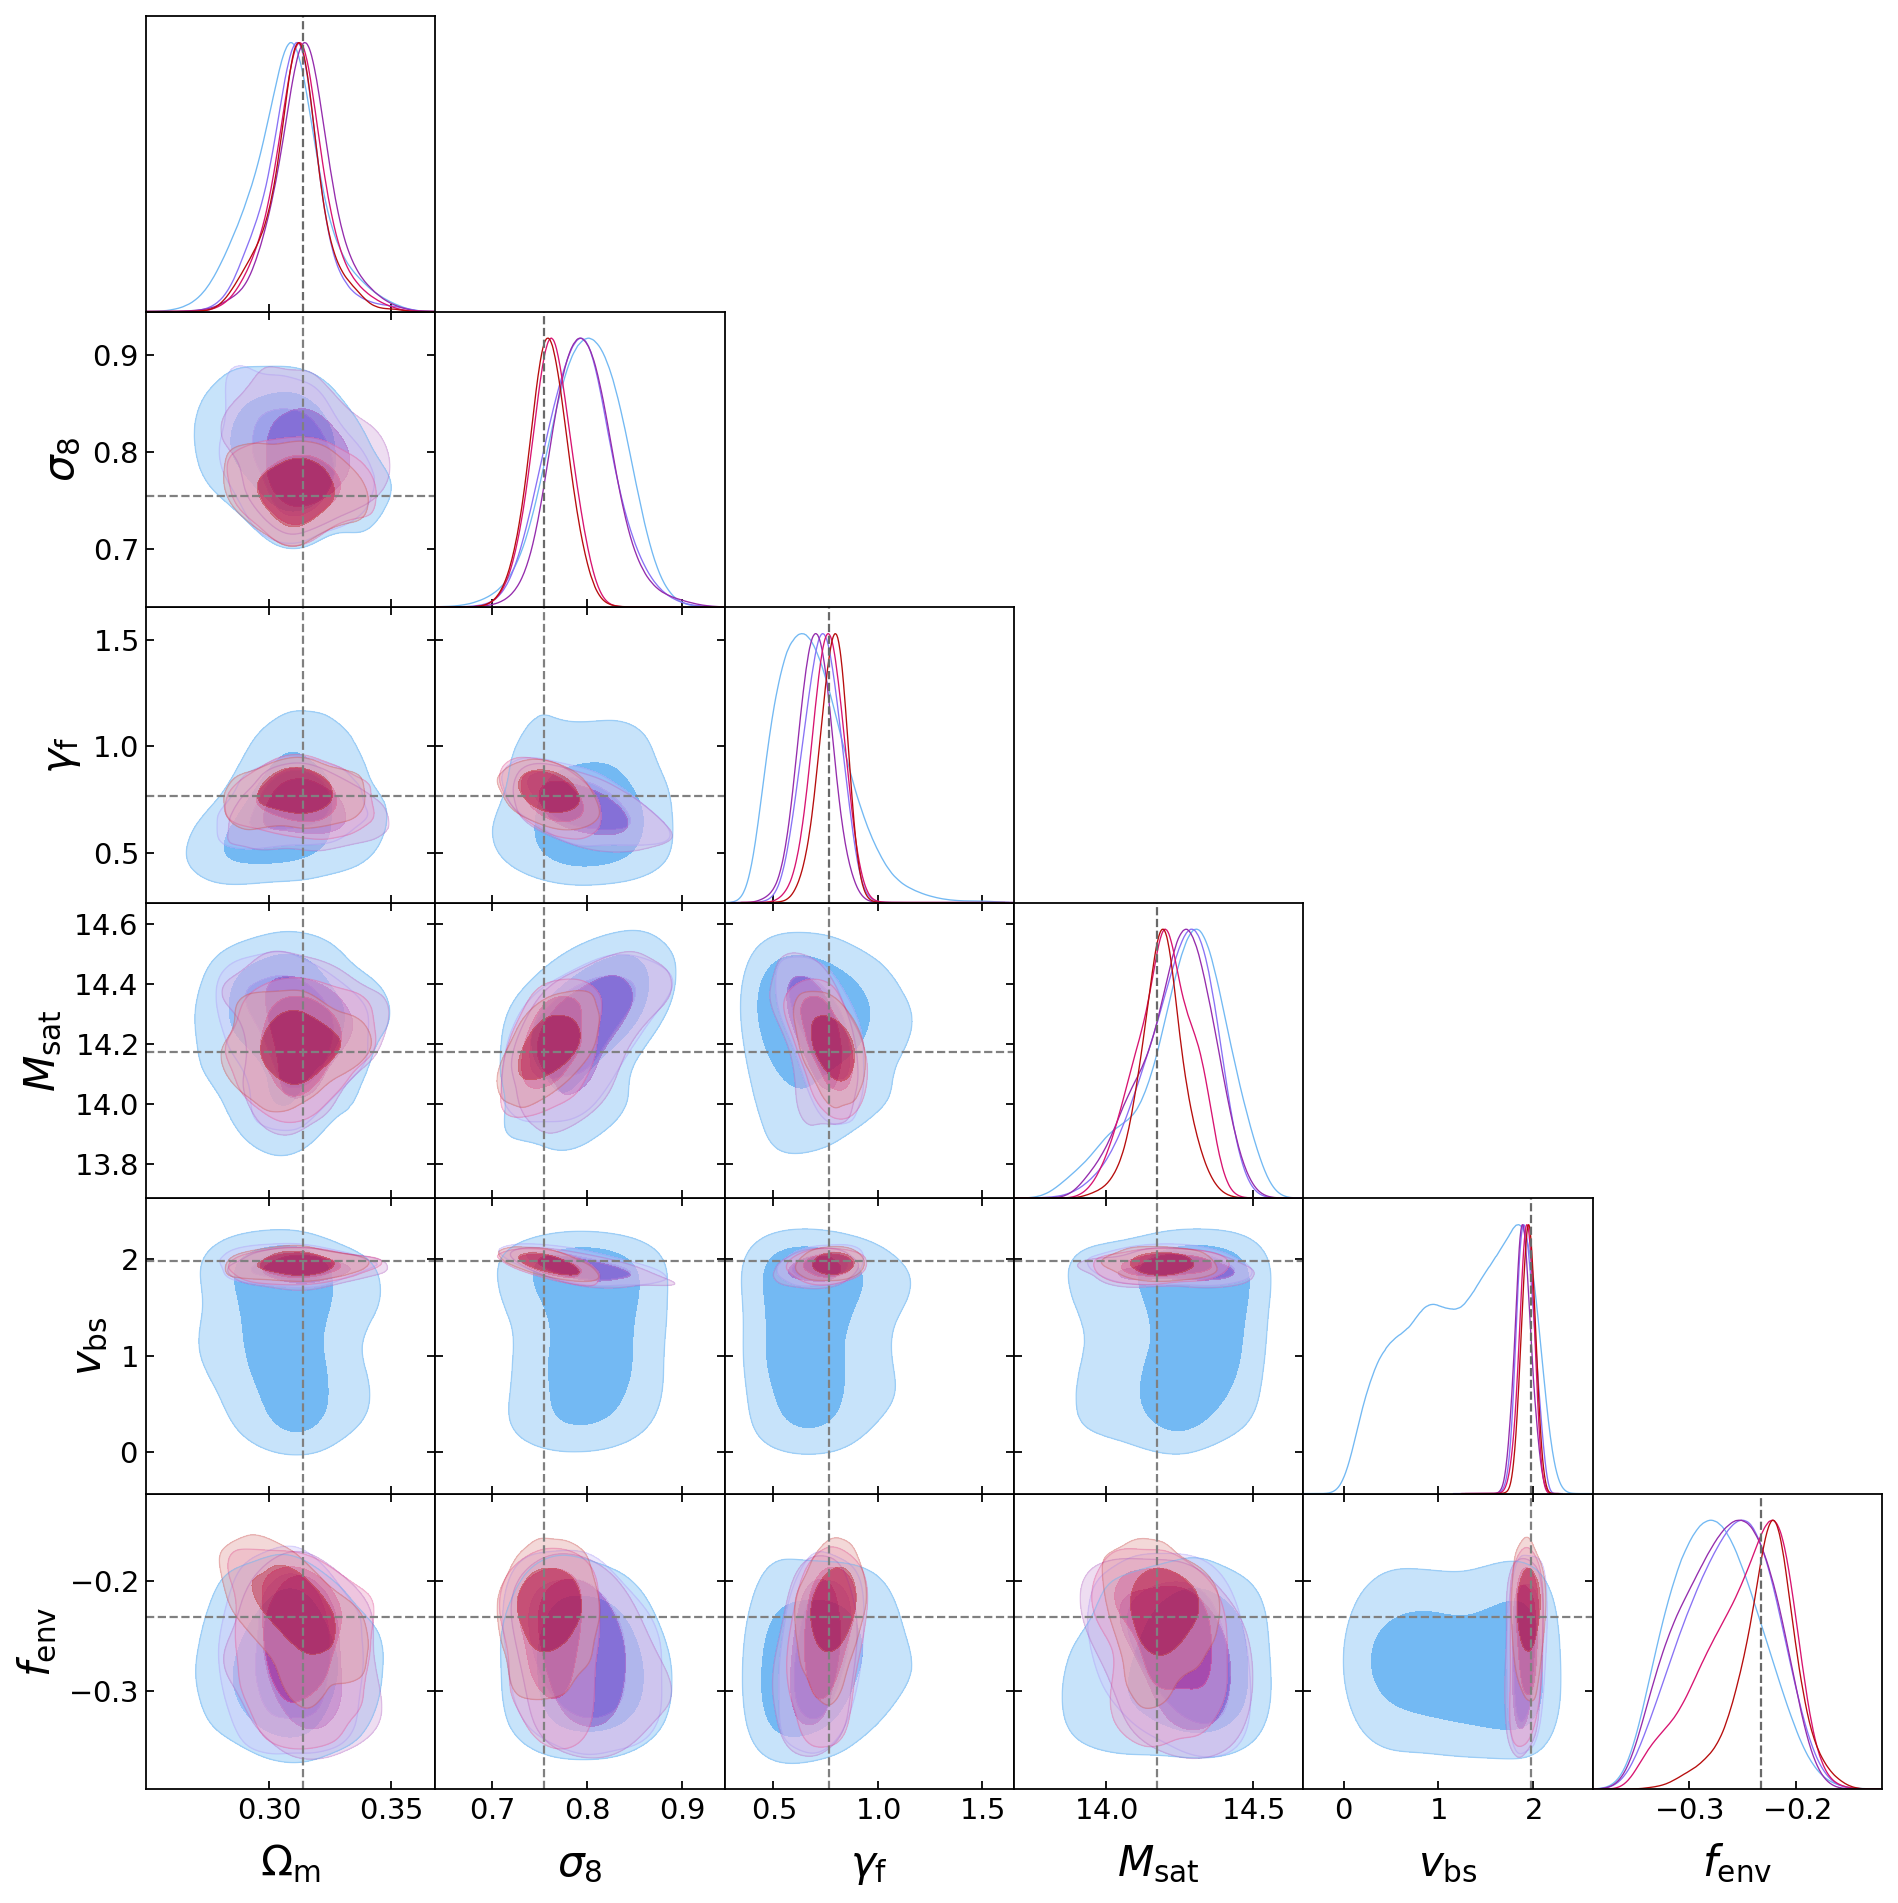

In [51]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, legend_labels=[],
                          colors=colors_addin,
                          params_toplot=params_keymix)
plt.savefig(f'{plot_dir}/contour_addin_keymix.pdf', bbox_inches='tight')

### Contour plot, single model recovery test: for emulator performance & smoothed covariance matrices, key cosmological parameters

Two models to show well-behaved and poorly behaved posteriors

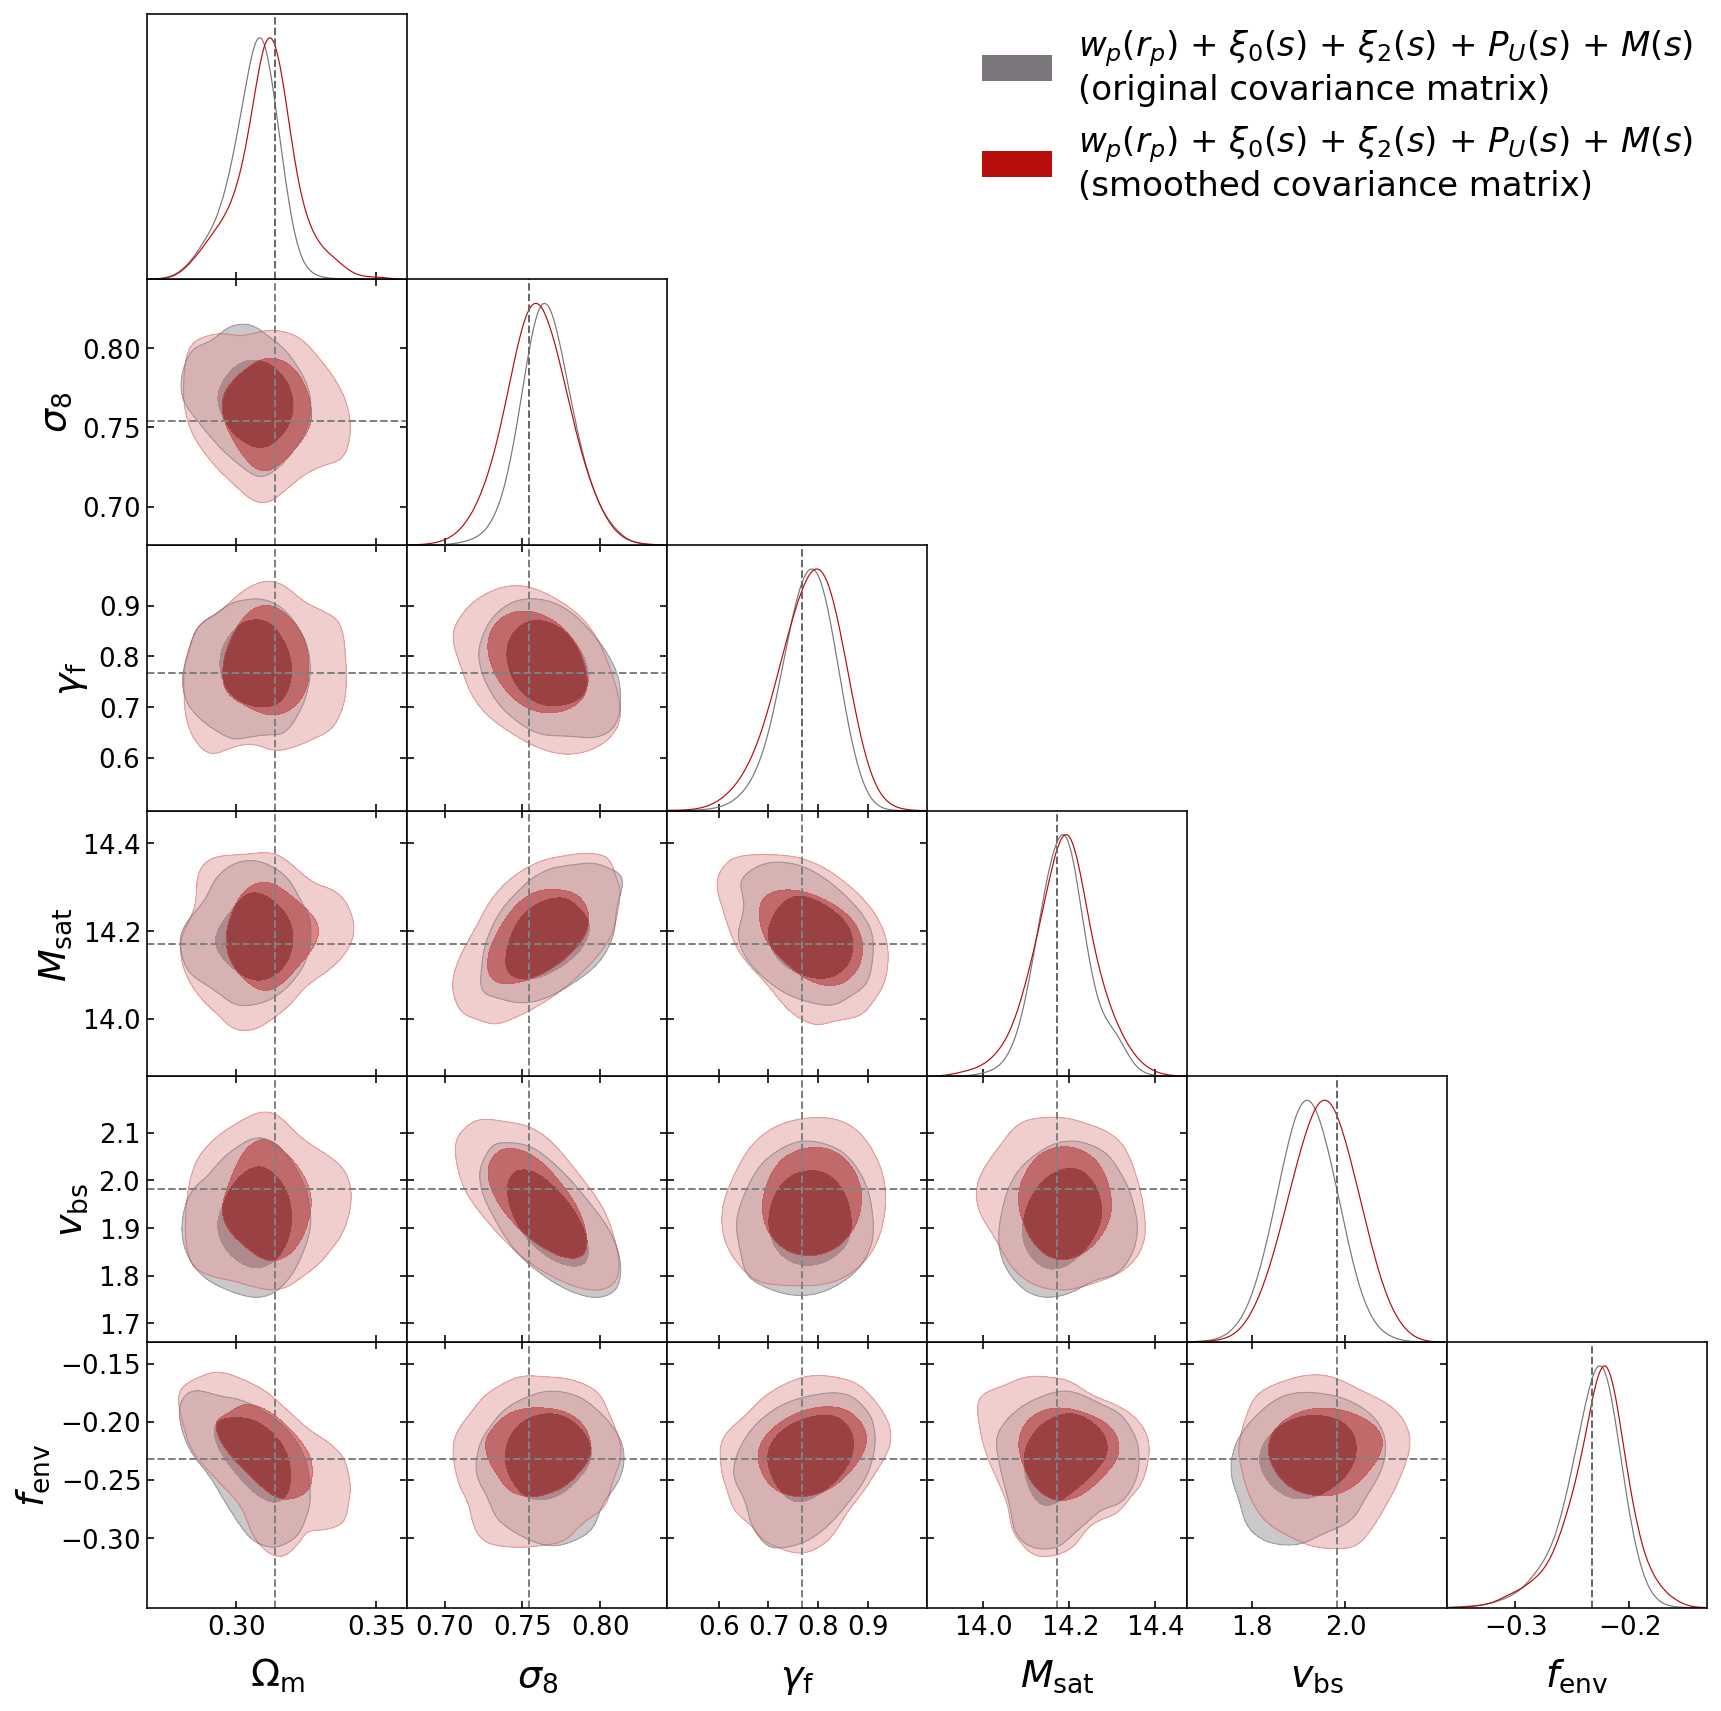

In [40]:
chaintags = [
             'wp_xi_xi2_upf_mcf_c1h12_all_covemuperf',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
labels_cov = [
             make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(original covariance matrix)',
             make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(smoothed covariance matrix)',
            ]
g = plotter.plot_contours(chaintags, legend_labels=labels_cov,
                          colors=colors_cov, legend_loc='upper right',
                          params_toplot=params_keymix, alpha=0.5)
plt.savefig(f'{plot_dir}/contour_cov_c1h12.pdf', bbox_inches='tight')

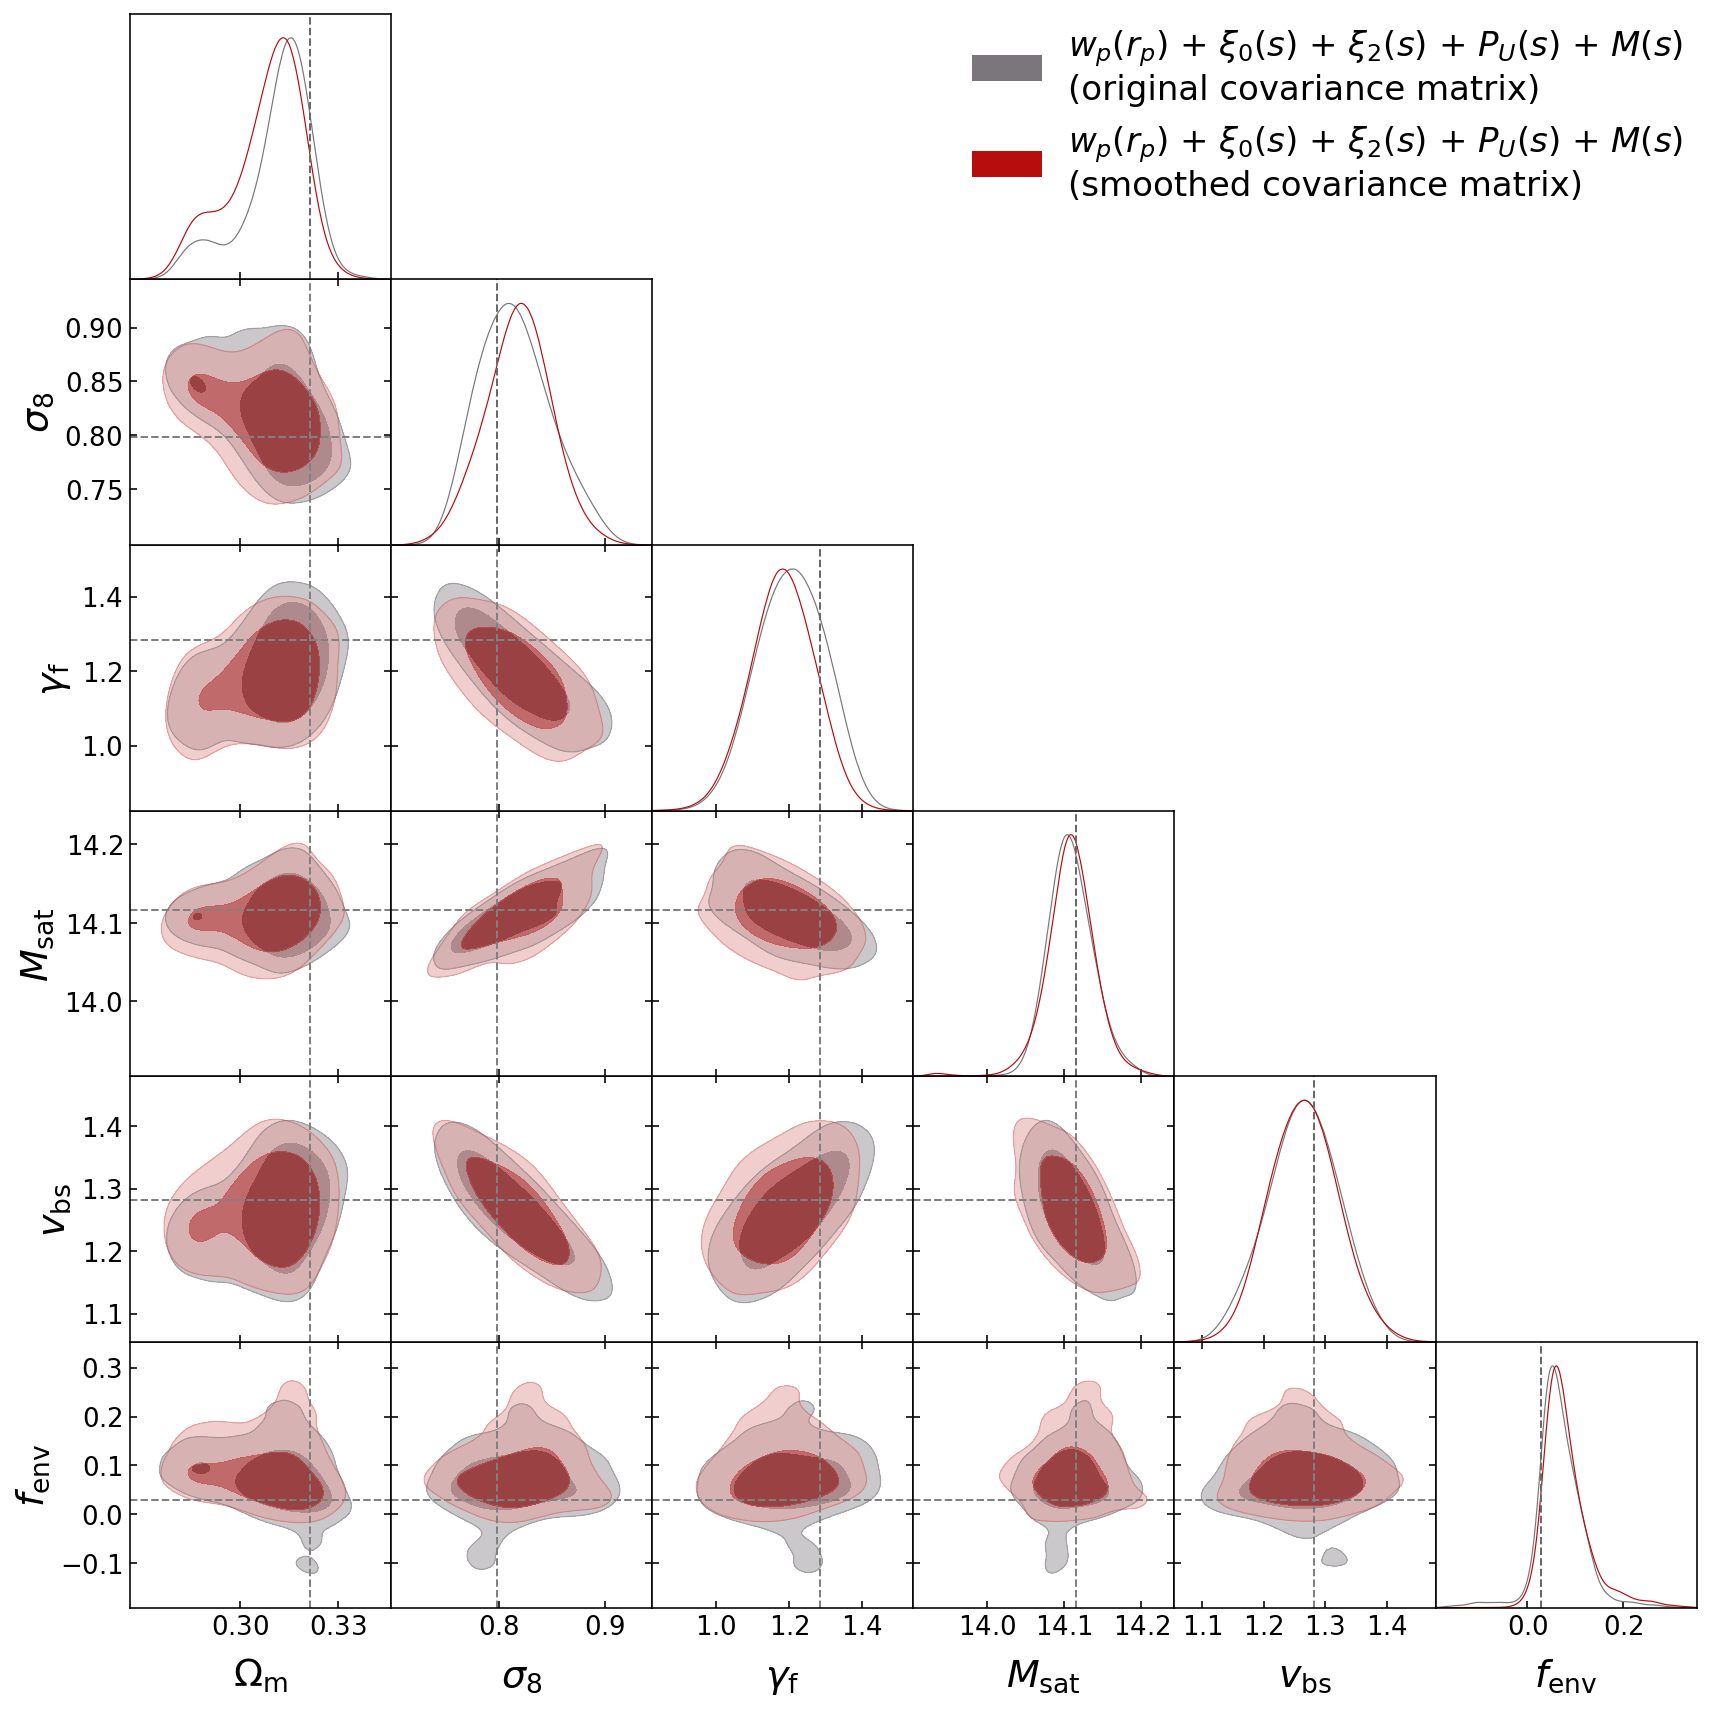

In [41]:
chaintags = [
             'wp_xi_xi2_upf_mcf_c6h62_all_covemuperf',
             'wp_xi_xi2_upf_mcf_c6h62_all_minscale0',
            ]
legend_labels = [
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(original covariance matrix)',
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf']) + '\n(smoothed covariance matrix)',
                ]
g = plotter.plot_contours(chaintags, legend_labels=legend_labels,
                          colors=colors_cov, legend_loc='upper right',
                          params_toplot=params_keymix, alpha=0.5)
plt.savefig(f'{plot_dir}/contour_cov_c6h62.pdf')

### 70-model recovery test: Precision on HOD and AB parameters

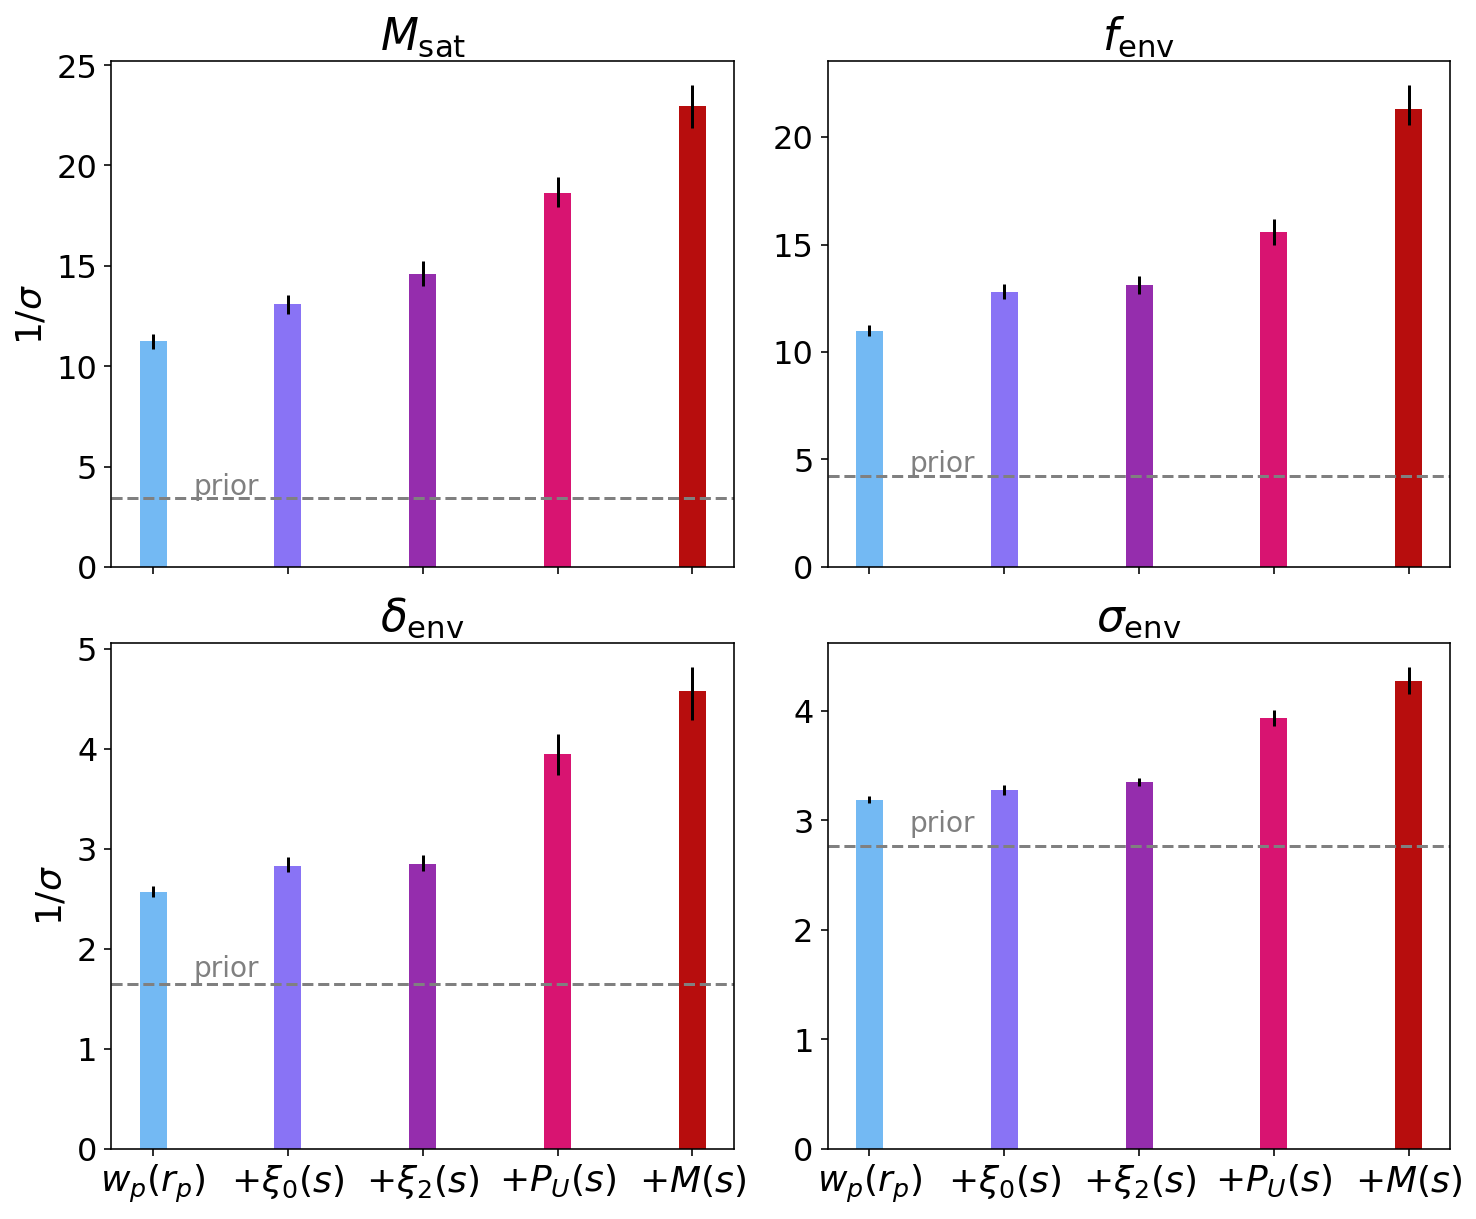

In [47]:
params_toplot = ['M_sat'] + ab_param_names
plotter.plot_uncertainty_figure(results_dict_addin_full, prior_dict, params_toplot, stat_strs_addin_full, 
                                id_pairs, labels_addin, colors_addin)
plt.savefig(f'{plot_dir}/recovery_hodab.pdf', bbox_inches='tight')